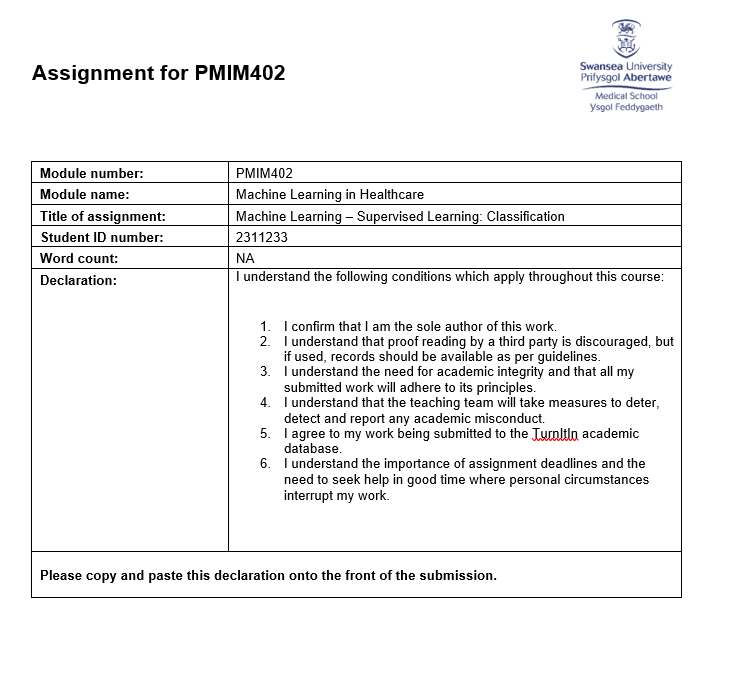

<h2>Heart Disease Classification using Logistic Regression and Random Forest</h2>

<h4>Table of Contents</h4><a class="anchor"  id="top"></a>

* [EDA](#eda)
    * [Visualization](#dp_viz)
        * [Missing Data](#dp_viz_missing)
        * [Data Distribution](#dp_viz_dist)
        * [Class Imbalance](#dp_class_imbalance)
        * [Outlier Treatment](#dp_viz_outlier)
    * [Encoding](#dp_enc)
* [Logistic Regression](#logreg)
    * [Performance Evaluation](#logreg_perf)
* [Random Forest](#rf)
    * [Performance Evaluation](#rf_perf)
* [ROC Analysis](#roc)
* [Random Forest: Hyperparameter tunning](#rf_tune)
* [Random Forest: Recursive Feature Selection](#rf_rfe)
* [Q&A](#qna)
* [References](#reference)

## EDA  <a class="anchor"  id="eda"></a>[↑](#top)

<hr/>

### Visualization  <a class="anchor"  id="dp_viz"></a>[↑](#top)



In [8]:
library(tidyverse)
library(naniar)
library(mice)
library(caret)
library(splitstackshape)
library(yardstick)
library(mlbench)
library(e1071)

#### Missing Data  <a class="anchor"  id="dp_viz_missing"></a>[↑](#top)

**Check the missing data in target column and features**

In [9]:
options(repr.plot.width = 16, repr.plot.height = 9)                 # to make plots bigger
set.seed(143)                                                       # good idea to set the random seed for reproducibility

In [10]:
getwd()

[1] "/kaggle/working"

In [11]:
dataset_path <- "../input/heart_disease_modified.csv"   # declare the datasetpath
dataset <- read_csv(dataset_path)                   # load the dataset

New names:
• `` -> `...1`
Rows: 920 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): pace_maker, drug, fam_hist
dbl (19): ...1, Patient_ID, sex, age, cp, trestbps, chol, fbs, restecg, thal...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
drop_columns <- c("...1", "Patient_ID")    #  declare the list of unwanted columns to drop
dataset_modified <- dataset %>%           #  drop columns 
    select(-one_of(drop_columns))
glimpse(dataset_modified)                 # view the glimpse of columns

Rows: 920
Columns: 20
$ sex        <dbl> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,…
$ age        <dbl> 67, 67, 62, 63, 53, 56, 48, 58, 58, 60, 40, 60, 64, 43, 57,…
$ pace_maker <chr> "NO", "NO", "NO", "NO", "NO", "NO", "NO", "NO", "NO", "NO",…
$ cp         <dbl> 4, 4, 4, 4, 4, 3, 2, 2, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4,…
$ trestbps   <dbl> 160, 120, 140, 130, 140, 130, 110, 120, 132, 130, 110, 117,…
$ chol       <dbl> 286, 229, 268, 254, 203, 256, 229, 284, 224, 206, 167, 230,…
$ fbs        <dbl> 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,…
$ restecg    <dbl> 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2,…
$ thalach    <dbl> 108, 129, 160, 147, 155, 142, 168, 160, 173, 132, 114, 160,…
$ exang      <dbl> 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,…
$ oldpeak    <dbl> 1.5, 2.6, 3.6, 1.4, 3.1, 0.6, 1.0, 1.8, 3.2, 2.4, 2.0, 1.4,…
$ perfusion  <dbl> 0.477572922, 0.780928415, 0.608129542, 0.176835867, -0.0858…
$ slope      <dbl>

In [13]:
# define the target column
target_column <- "class"               
# define numerical columns
numeric_columns <- c("age", "trestbps", "chol", "thalach", "oldpeak", "perfusion", "ca", "traponin", "thal")
continous_columns <- c("age", "trestbps", "chol", "oldpeak", "perfusion", "traponin")
# define categorical columns
categorical_columns <- c("sex", "cp", "pace_maker", "fbs", "exang", "smoker", "drug", "fam_hist", "restecg", "slope")

discrete_columns <- c("ca", "sex", "cp", "fbs", "exang", "smoker", "restecg", "slope")
# define columns to be encoded 
to_encode_columns <- c("pace_maker", "drug", "fam_hist")

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


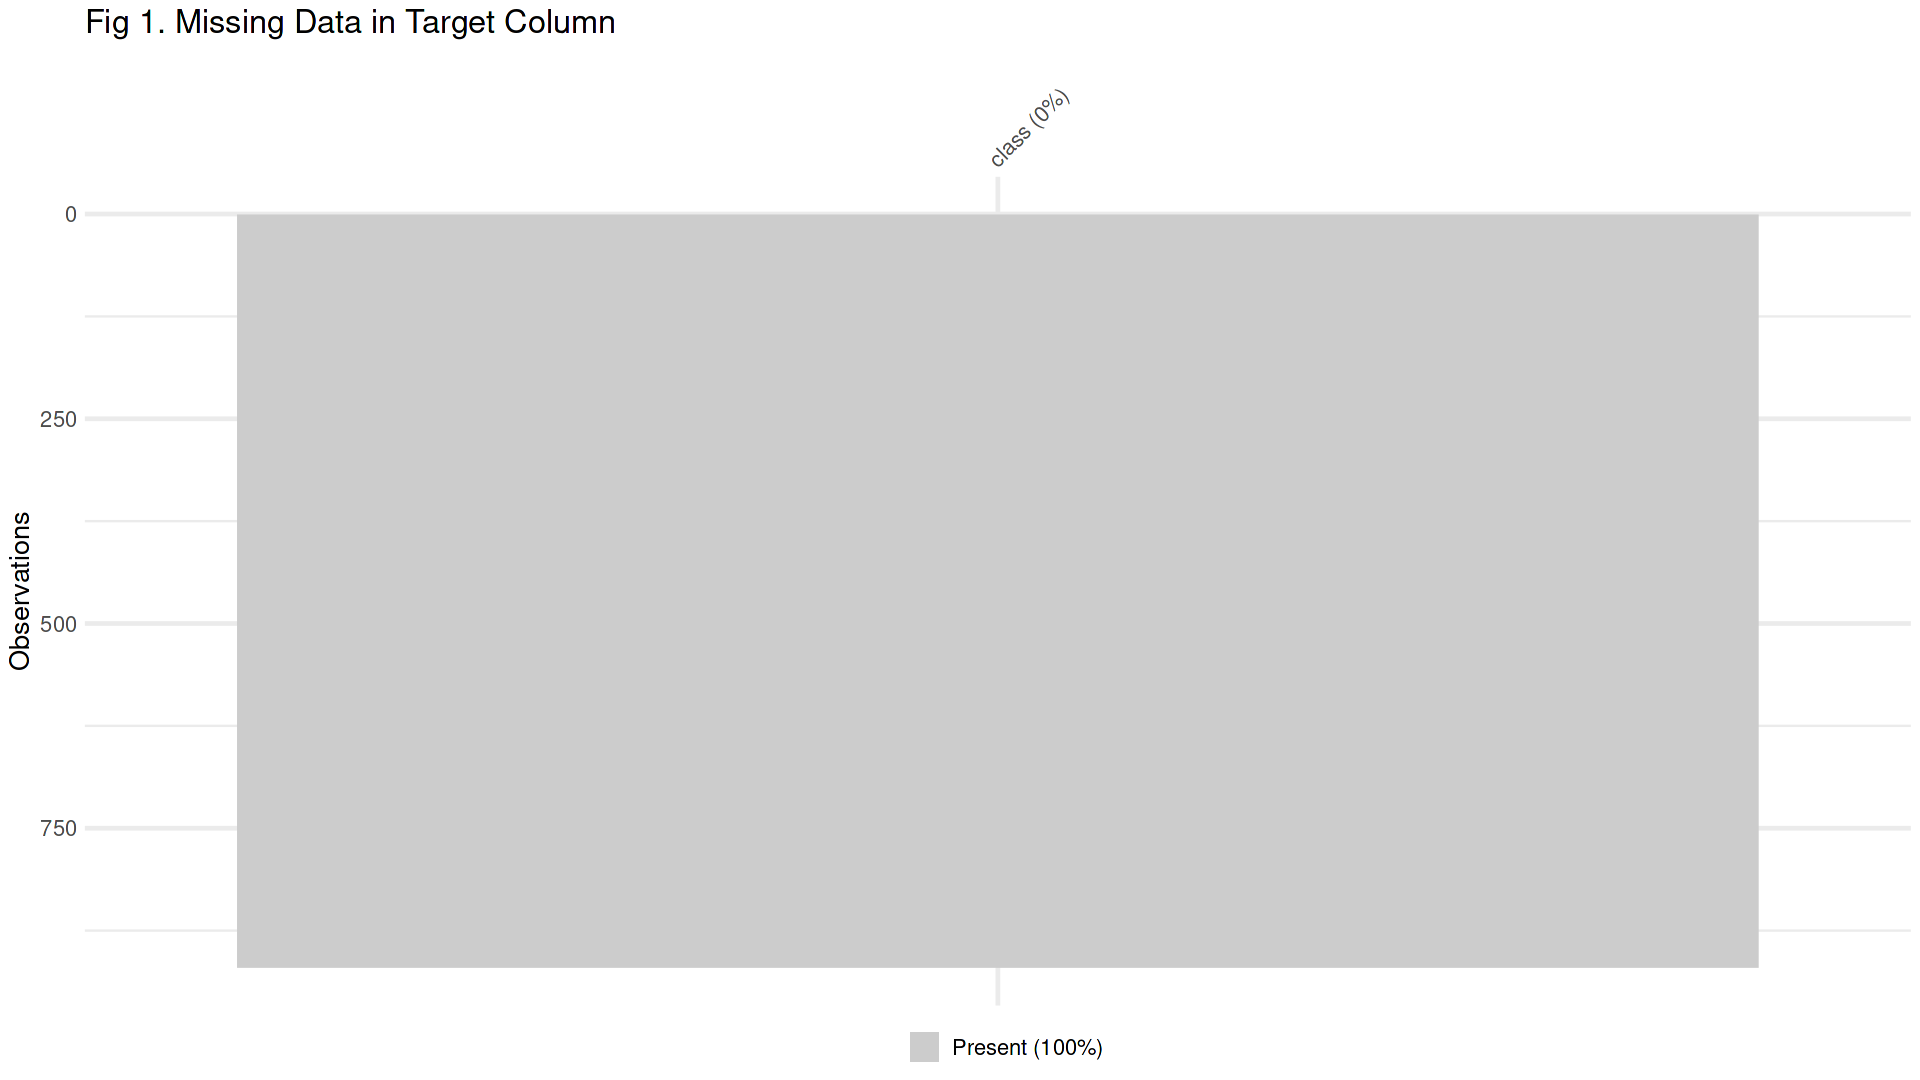

In [14]:
dataset_modified %>%                   # identify the missing values in the dataset for target column
    select(all_of(target_column)) %>%
    vis_miss() +                        # Result: no missing data found
    labs(title="Fig 1. Missing Data in Target Column") +
    theme(text = element_text(size = 16), element_line(size = 1))

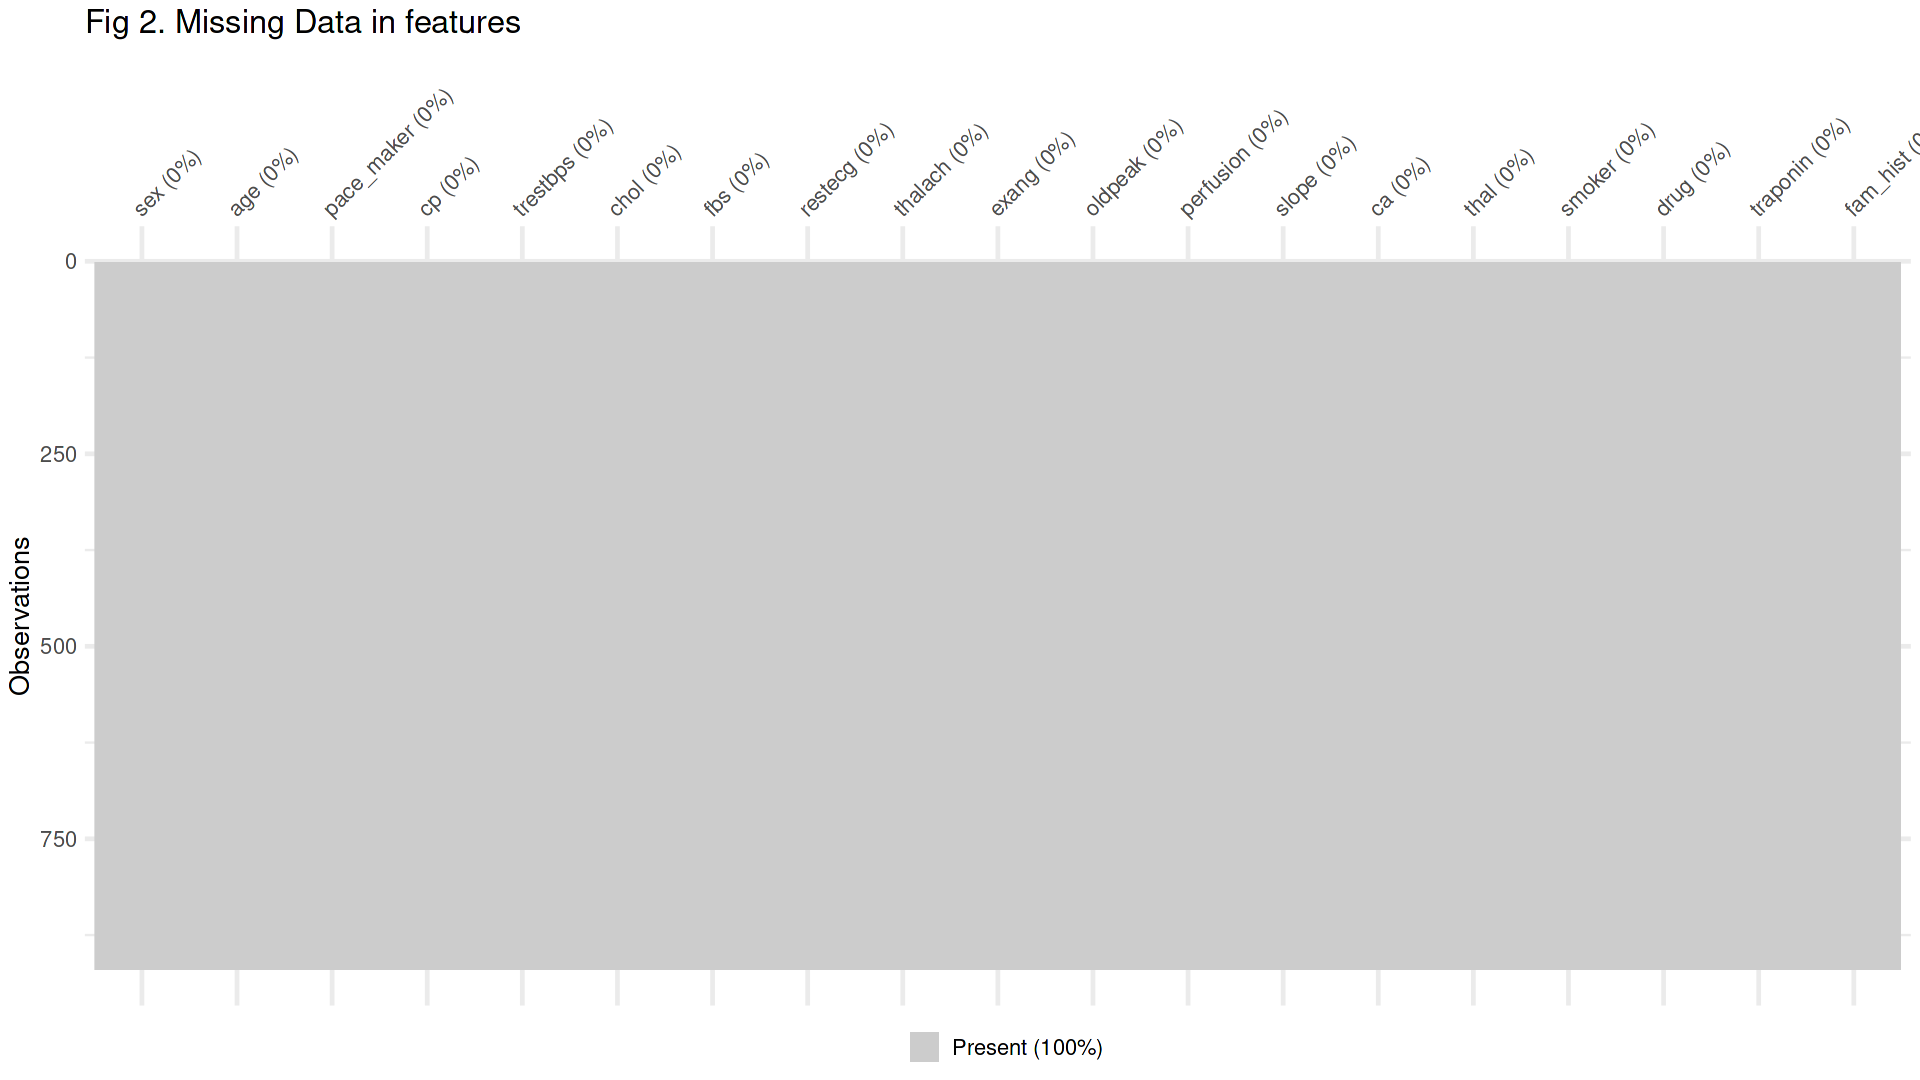

In [15]:
dataset_modified %>%                   # identify the missing values in the dataset for all columns
    select(-one_of(target_column)) %>%
    vis_miss() +                       # Result: no missing data found
    labs(title="Fig 2. Missing Data in features") +
    theme(text = element_text(size = 16), element_line(size = 1))

#### Data Distribution  <a class="anchor"  id="dp_viz_dist"></a>[↑](#top)

**Check the distribution of features and inspect for abnormalities**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


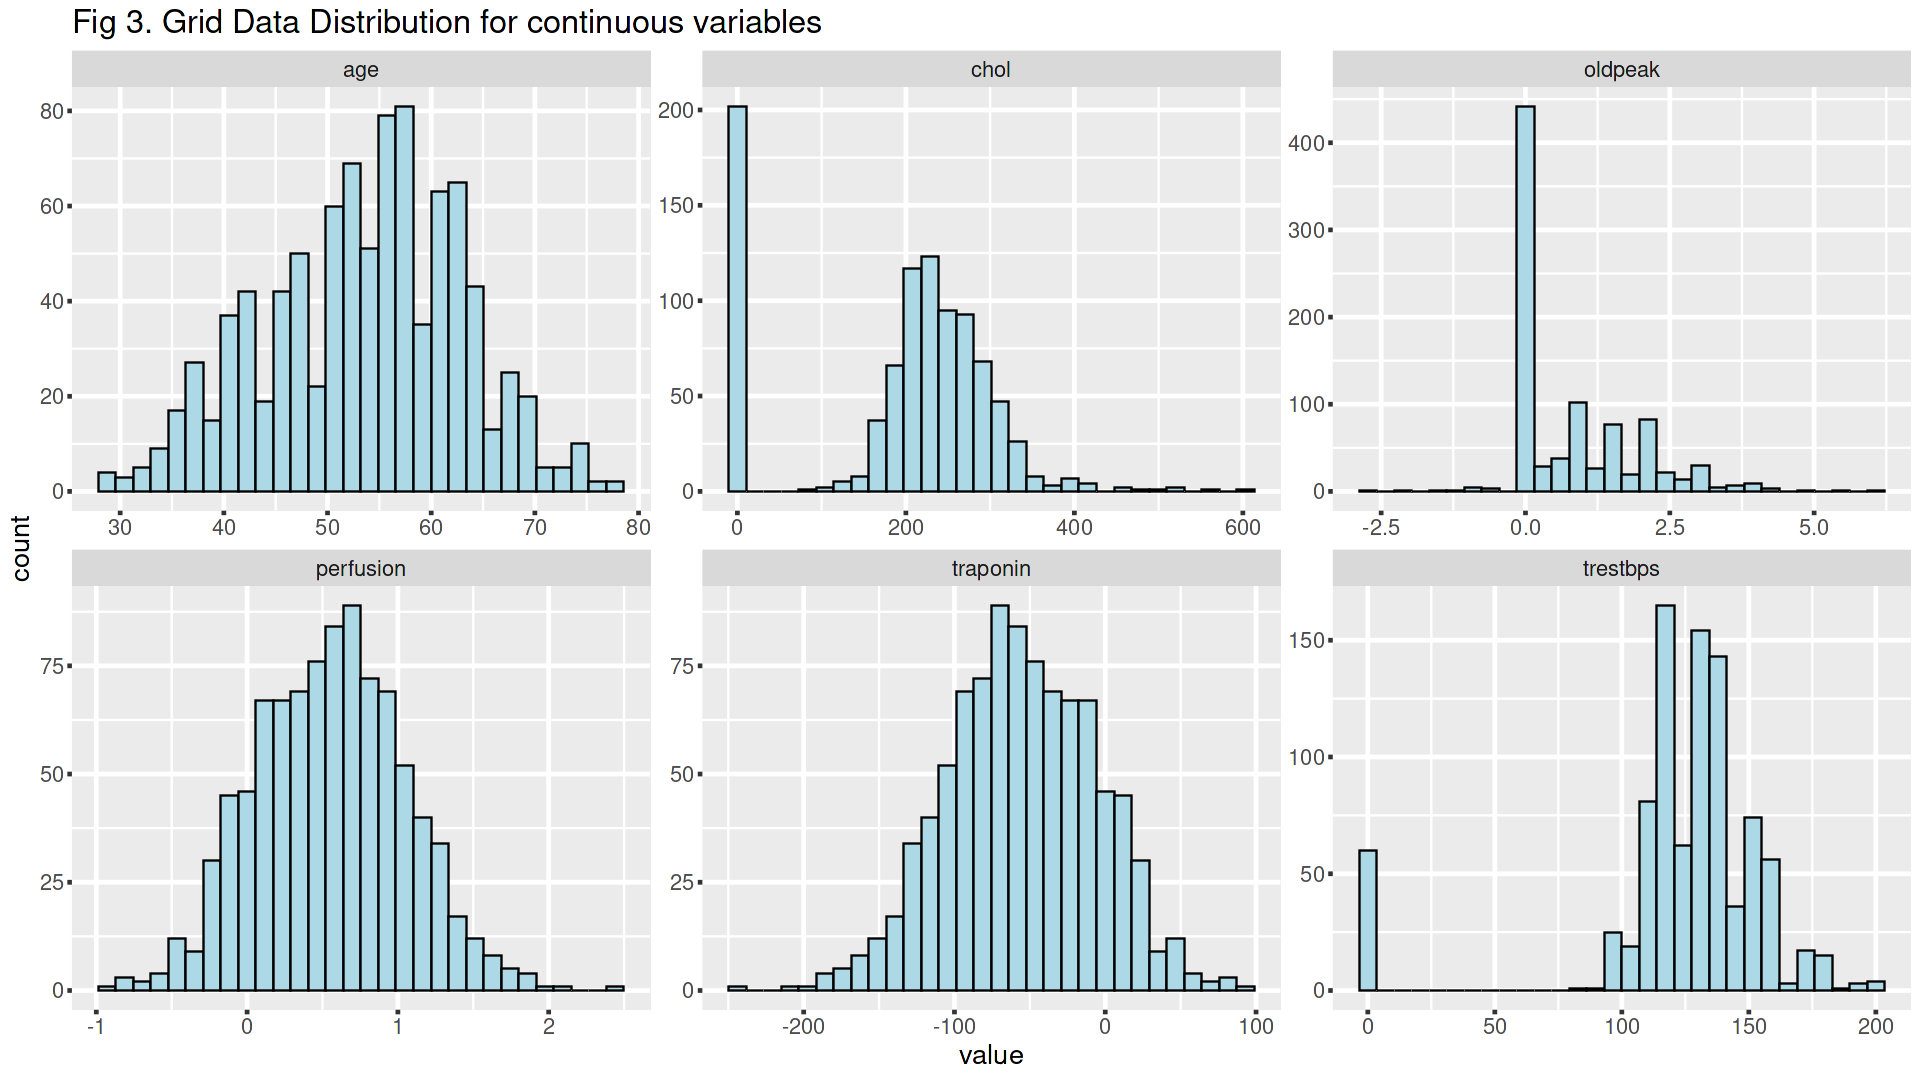

In [16]:
# data distribution for continous numeric columns
dataset_dist <- dataset_modified %>% 
    select(all_of(continous_columns))
    
dataset_dist <- dataset_dist %>% 
    gather(attributes, value, 1:ncol(dataset_dist))

ggplot(data=dataset_dist, aes(x=value)) +
   geom_histogram(stat="bin", fill="lightblue", color="black") +
   labs(title="Fig 3. Grid Data Distribution for continuous variables") +
   facet_wrap(~attributes, scales="free") +
   theme(text = element_text(size = 16), element_line(size = 1))

> - *There are large number of zeros in the 'chol', 'oldpeak', 'trestbps' columns is it normal or abnormal ?* 
> - To check which age group has the cholestrol, oldpeak and trestbps as zeros, why ? Because, if there is any specific age group where the zero values fall in, then logical strategies could be devised based on internet research about general values associated to the specific age group, if not then such values could be converted to NA and then imputed.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


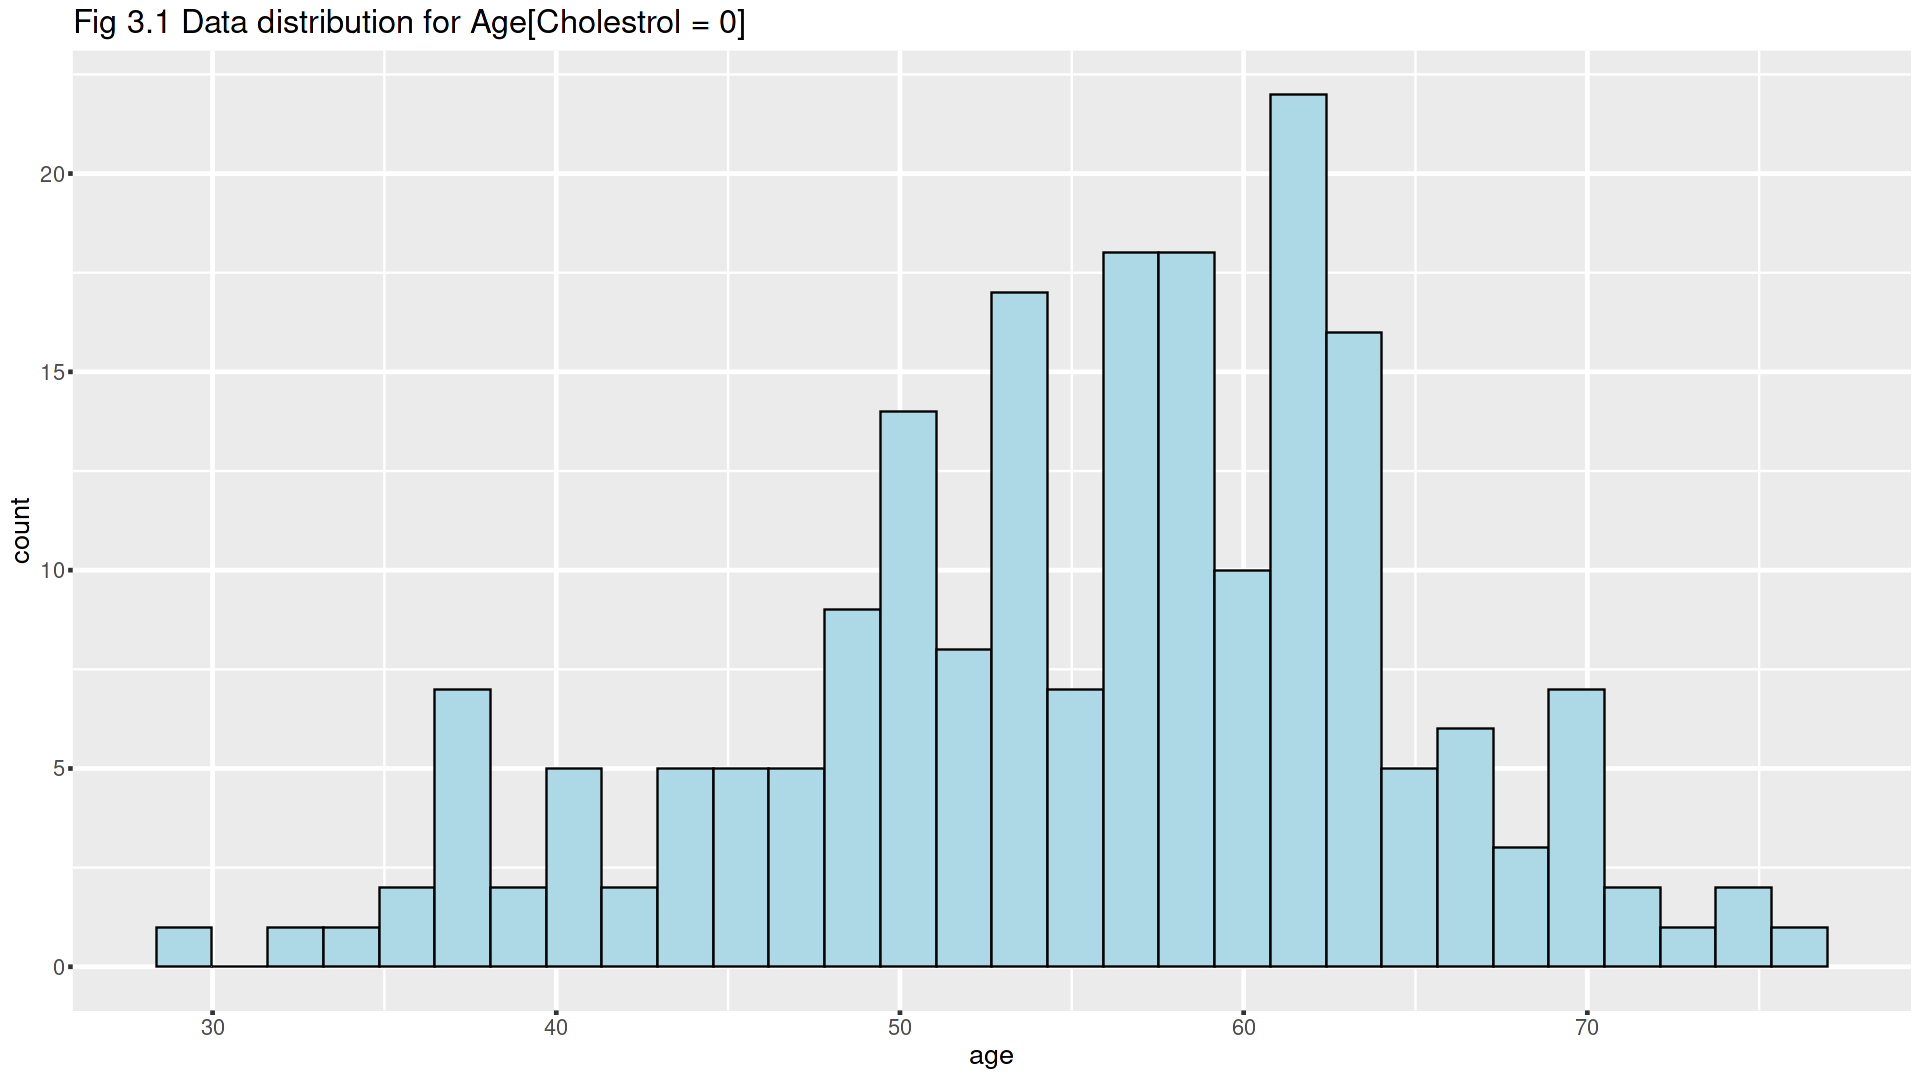

In [17]:
dataset_modified %>%
    filter(chol == 0) %>%
    ggplot(aes(x=age)) +
        geom_histogram(stat="bin", fill="lightblue", color="black") +
        labs(title="Fig 3.1 Data distribution for Age[Cholestrol = 0]") +
        theme(text = element_text(size = 16), element_line(size = 1))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


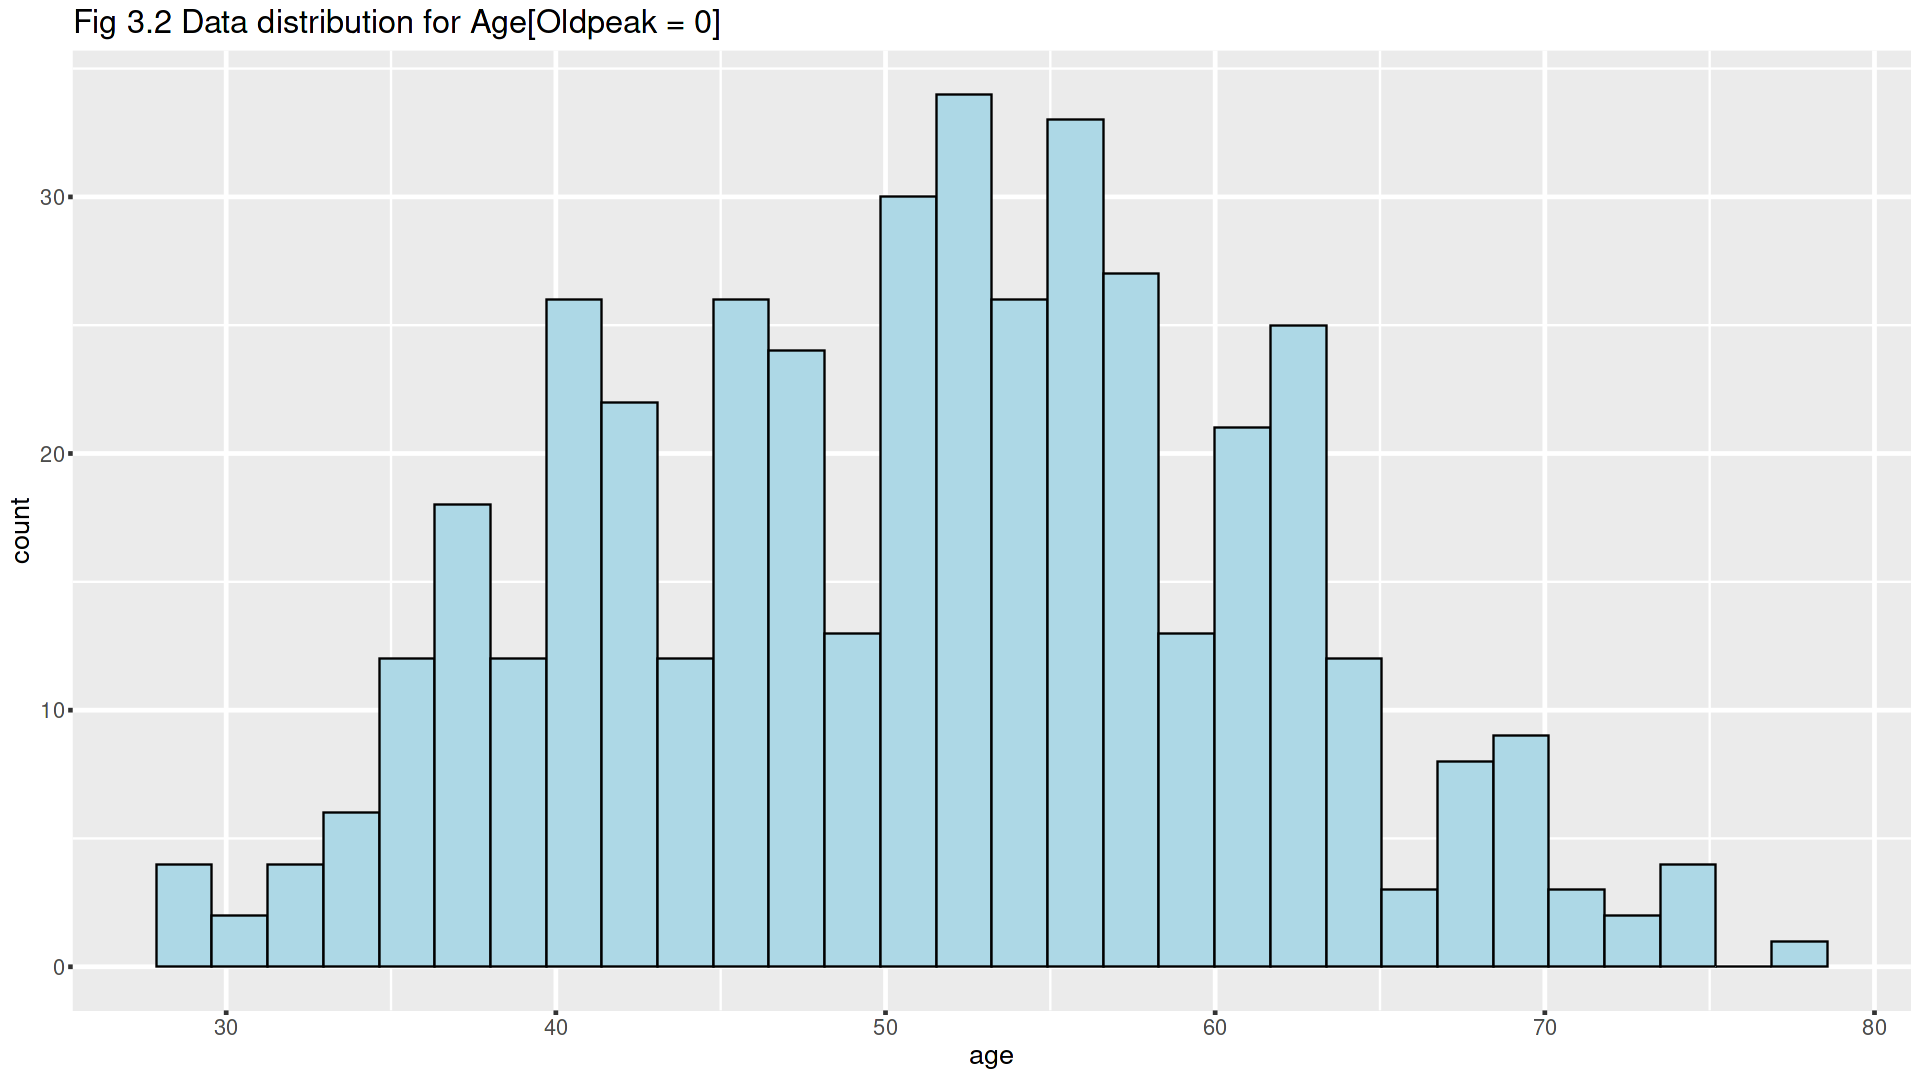

In [18]:
dataset_modified %>%
    filter(oldpeak == 0) %>%
    ggplot(aes(x=age)) +
        geom_histogram(stat="bin", fill="lightblue", color="black") +
        labs(title="Fig 3.2 Data distribution for Age[Oldpeak = 0]") +
        theme(text = element_text(size = 16), element_line(size = 1))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


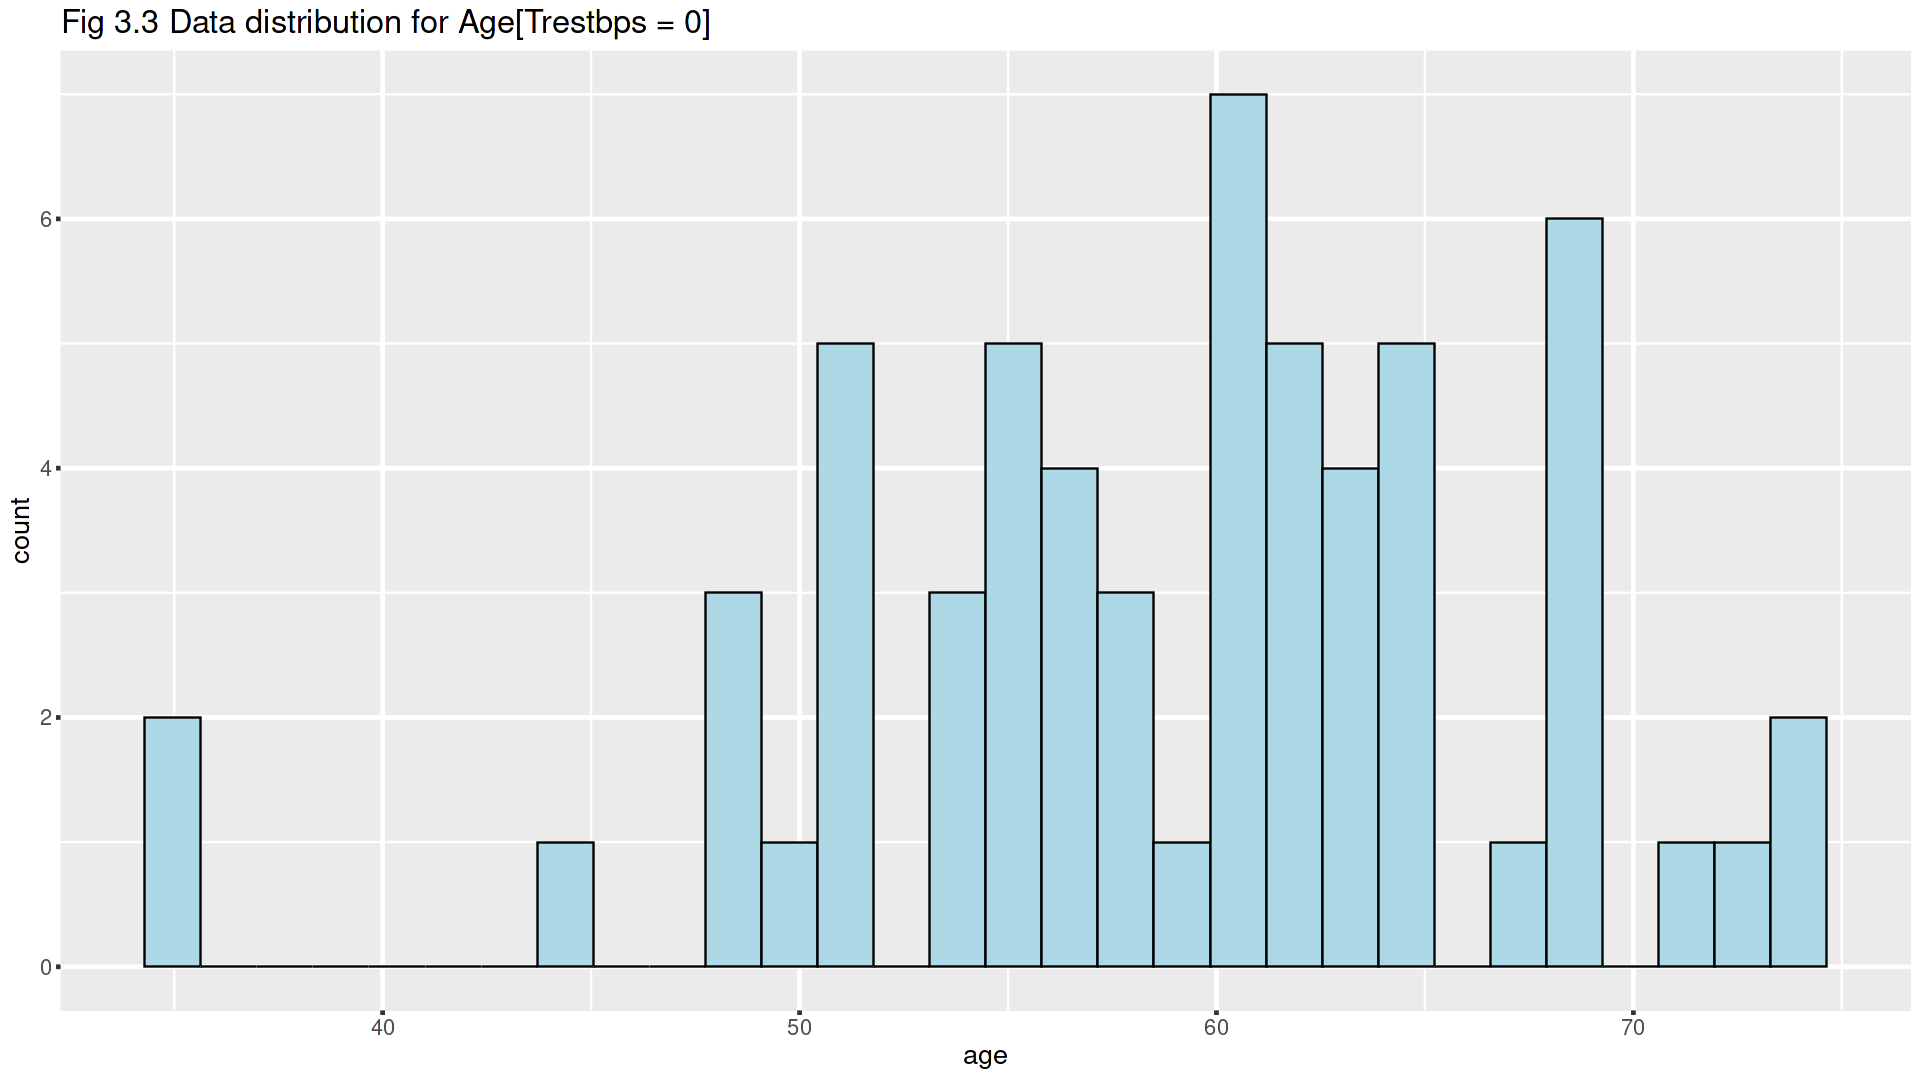

In [19]:
dataset_modified %>%
    filter(trestbps == 0) %>%
    ggplot(aes(x=age)) +
        geom_histogram(stat="bin", fill="lightblue", color="black") +
        labs(title="Fig 3.3 Data distribution for Age[Trestbps = 0]") +
        theme(text = element_text(size = 16), element_line(size = 1))

> - From `Figure 3.1 - 3.3`, it could be derived that, the value of zero for the three columns are distributed across age agroups and not specific to any one. It is possible that it might be a systematic noise.

**Handling Oldpeak** column
   > - Oldpeak column is defined as ST depression relative to rest. the value is measured based on difference between the normal line and the depression ECG in ECG reading. As seen in the image below. 
   > - It could be considered logically that negative depression could mean positive elevation, but then the importance of slop field that provides the direction of slope ( upslope / downslope ) would be rendered meaningless as well. Thus based on this thought process, the `oldpeak values < 0` are considered as systematic errors and converted as NA values.
   
 [(1–3)](#reference)

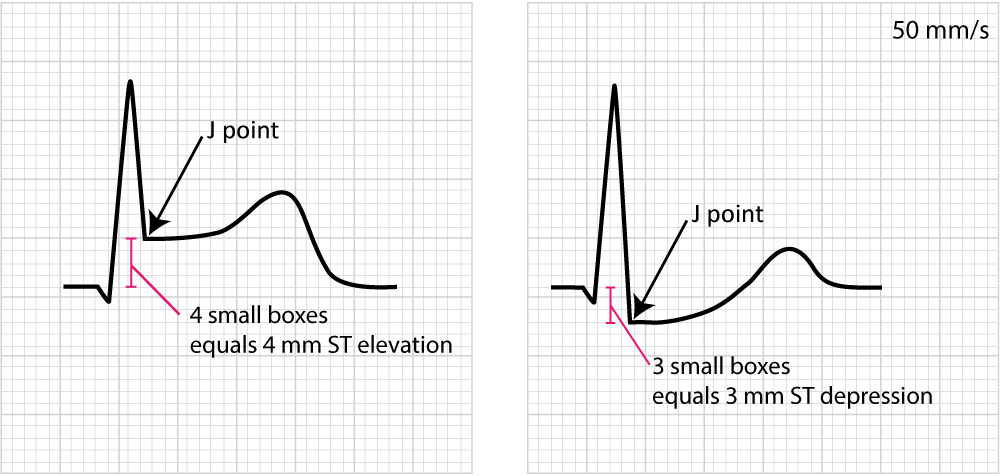

In [20]:
dataset_modified <- dataset_modified %>%
    mutate(oldpeak=ifelse(oldpeak < 0, NA, oldpeak))

**Handling Chol** column
> - Cholestrol levels can be low but cannot be zero

In [21]:
dataset_modified <- dataset_modified %>%
    mutate(chol=ifelse(chol == 0, NA, chol))

**Handling TrestBPS** column

> - Resting BloodPressure levels (it can be low) but cannot be zero, 

In [22]:
dataset_modified <- dataset_modified %>%
    mutate(trestbps=ifelse(trestbps == 0, NA, trestbps))

**Handling Troponin** column

> - It is unclear from the data dictionary if the column is Troponin T or Troponin I.
> - It follows normal distribution and the values are not in typical range found in the resources.
> - Thus, dropping the troponin column is preferred inorder to not add noise to the feature matrix.

[(4)](#reference)

In [23]:
dataset_modified <- dataset_modified %>%
    select(-traponin)

Warning message in geom_histogram(stat = "count", fill = "lightblue", color = "black"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


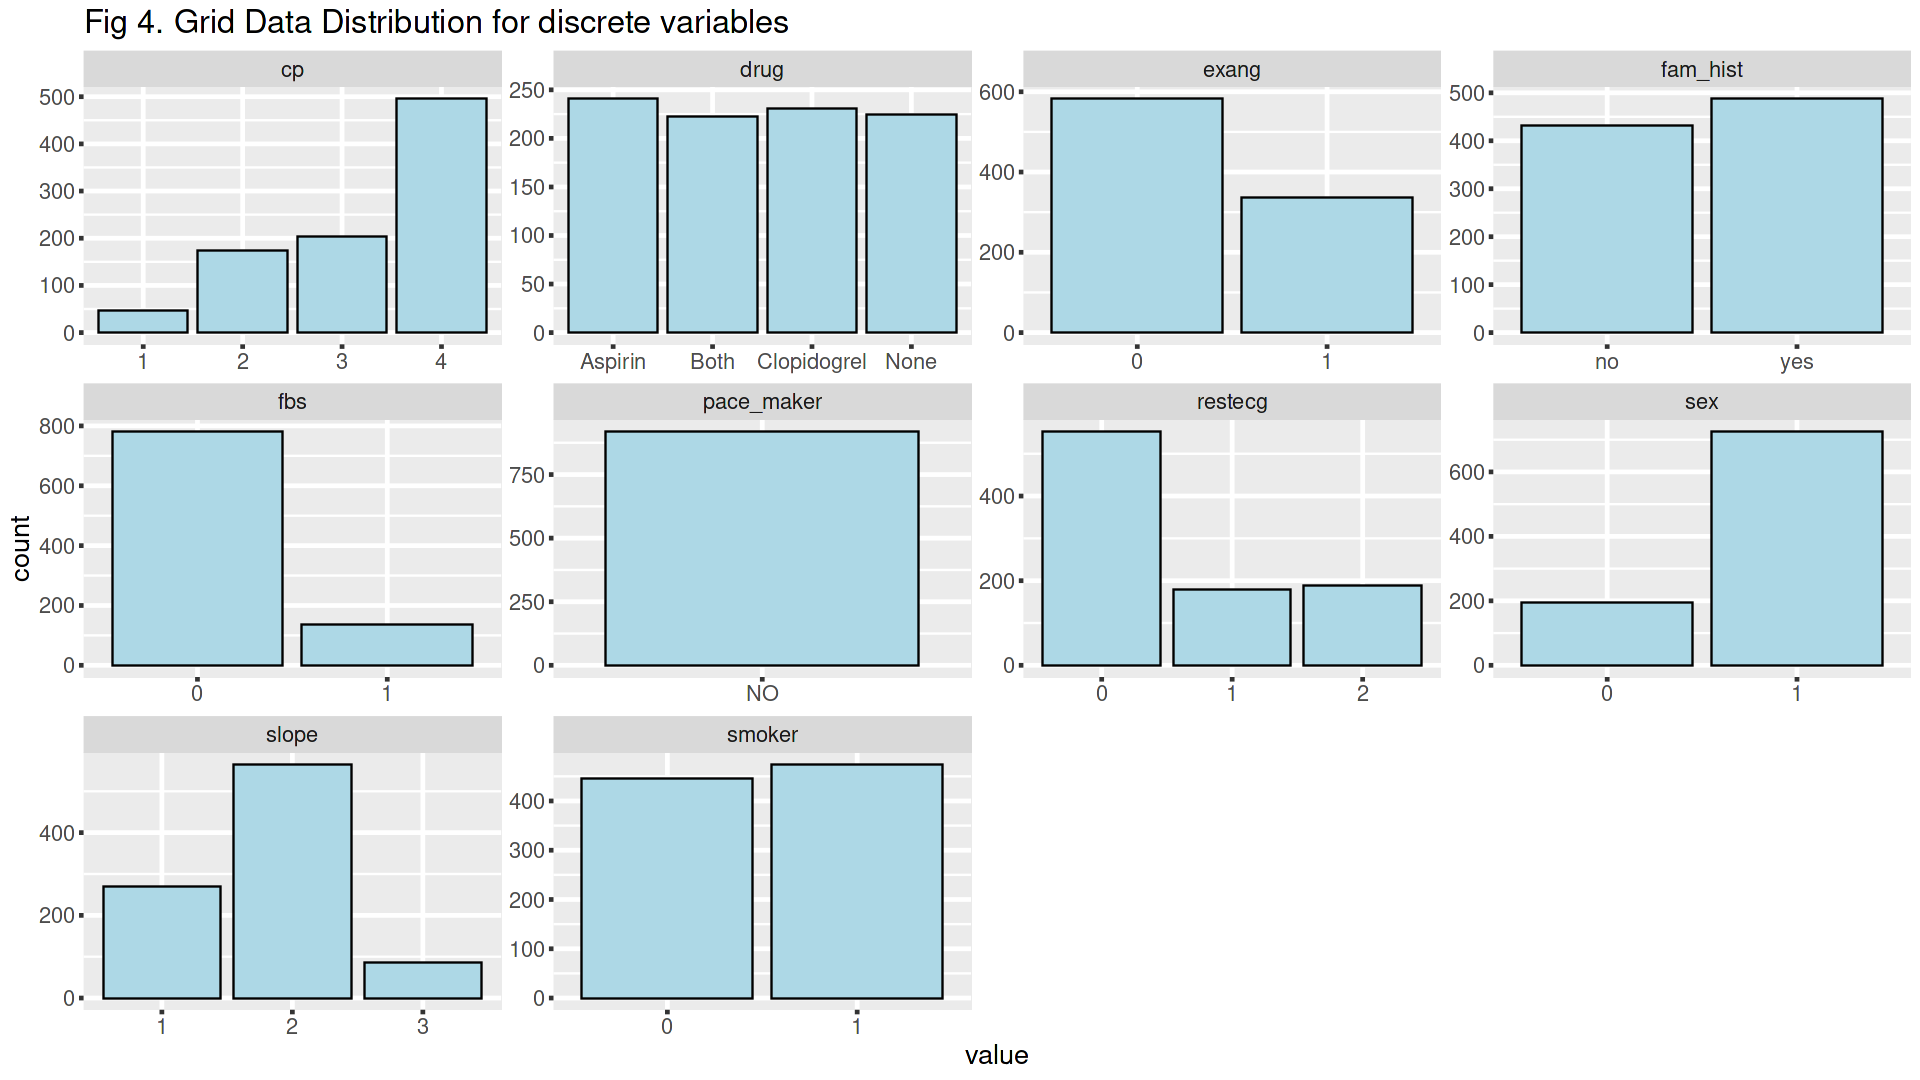

In [24]:
# data distribution for discretet numeric columns
dataset_dist <- dataset_modified %>% 
    select(all_of(categorical_columns))

dataset_dist <- dataset_dist %>%
    gather(attributes, value, 1:ncol(dataset_dist))

ggplot(data=dataset_dist, aes(x=value)) +
    geom_histogram(stat="count", fill="lightblue", color="black") +
    labs(title="Fig 4. Grid Data Distribution for discrete variables") +
    facet_wrap(~attributes, scales="free") +
    theme(text = element_text(size = 16), element_line(size = 1))

In [25]:
dim(dataset_modified)

[1] 920  19

**Handling Pace_maker** column

> - Pace maker column has only 1 value that is zero. Adding them would not provide any additional as there is no pattern to derived from this column. Thus, the column is dropped.

In [26]:
dataset_modified <- dataset_modified %>%
    select(-one_of("pace_maker"))

dim(dataset_modified)

[1] 920  18

#### Class Imbalance  <a class="anchor"  id="dp_class_imbalance"></a>[↑](#top)
**To check if the target column is balanced**

Warning message in geom_histogram(stat = "count", fill = "lightblue", color = "black"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


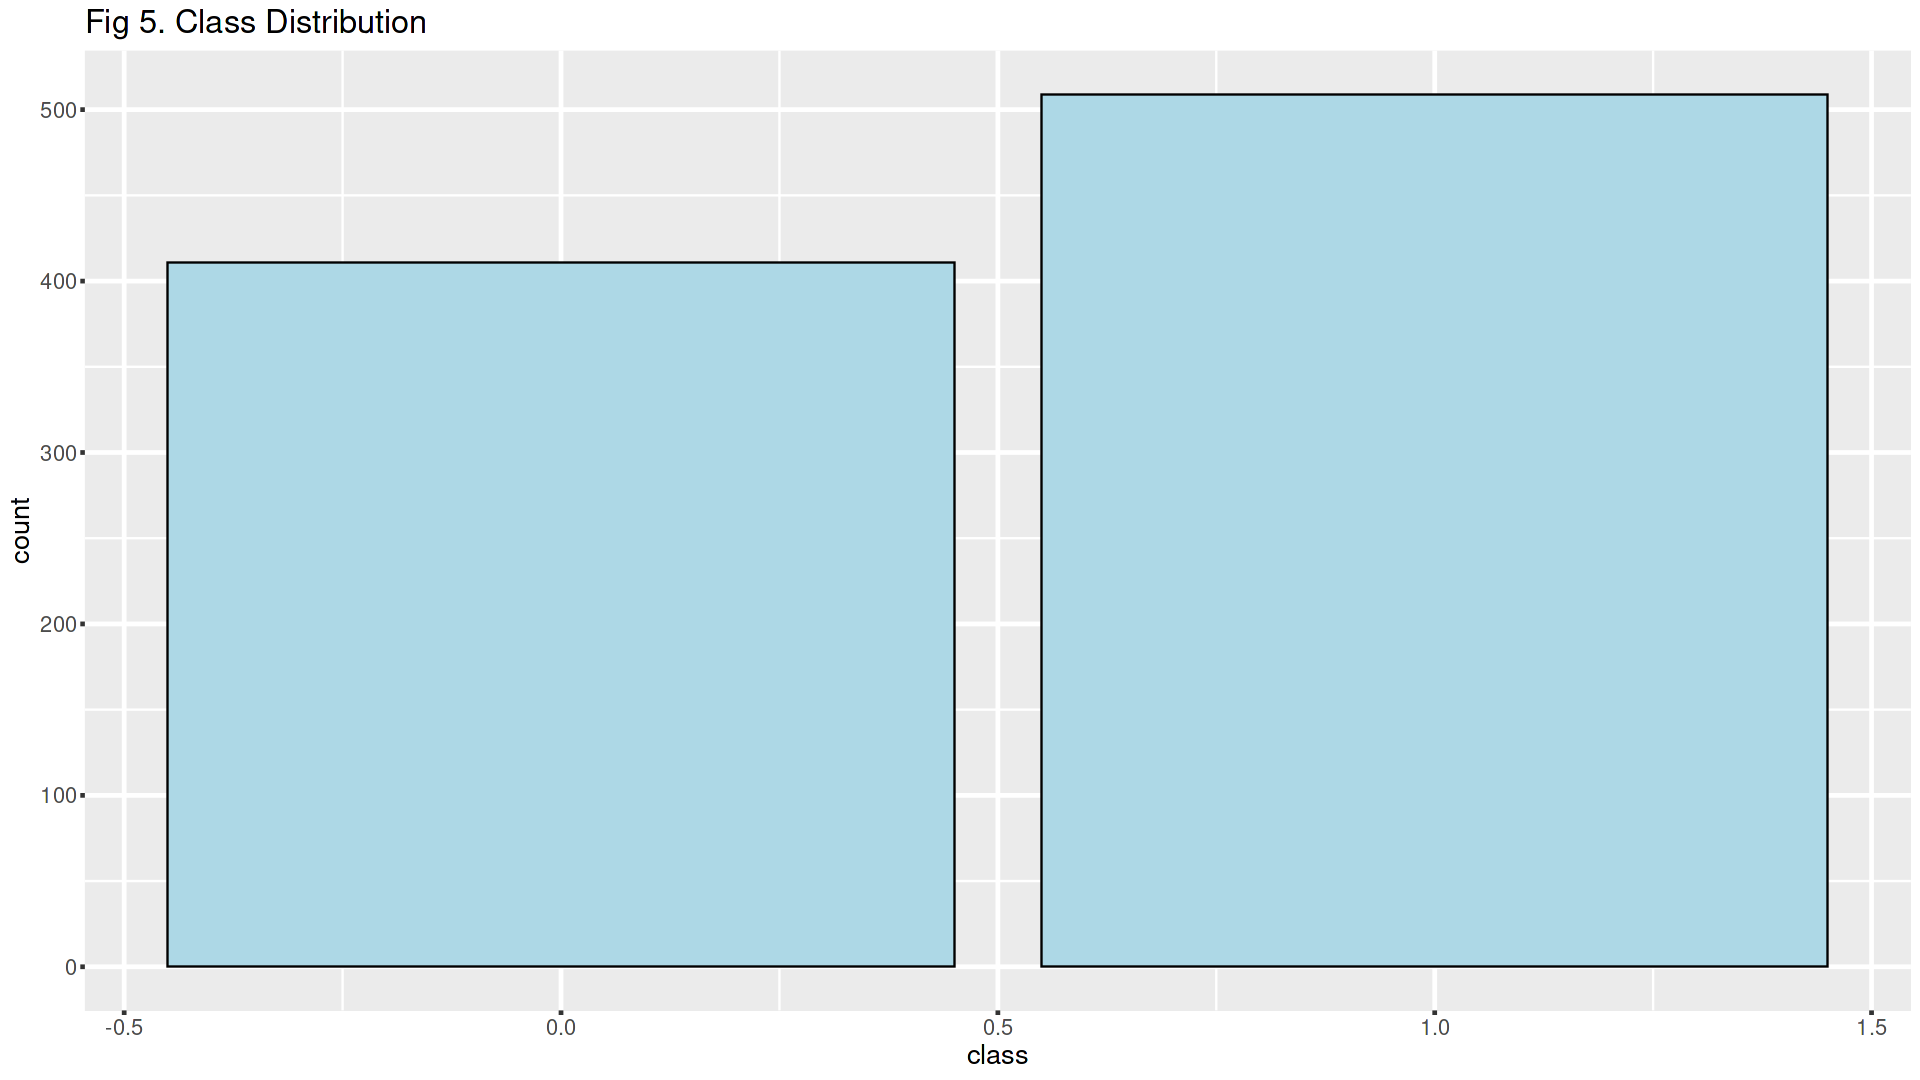

In [27]:
ggplot(data=dataset_modified, aes(x=class)) +
    geom_histogram(stat="count", fill="lightblue", color="black") +
    labs(title="Fig 5. Class Distribution") +
    theme(text = element_text(size = 16), element_line(size = 1))

> - This shows that there is only mild class imbalance in the dataset

### Encoding  <a class="anchor"  id="dp_enc"></a>[↑](#top)

**Handling Age** column

> - Age column is continuous and to make more logical perspective like, `the age-group of people associated with heart disease` the column could be binned

In [28]:
bin_age_feature <- function(data){
    #' @description 
    #' A function to bin the age into groups
    #' 
    #' @param data, data to work on
    #'
    #' @example 
    #'  data <- bin_age_feature(data)
    #' 
    #' 
    #' @return split_data, named list containing the train and test dataset
    # binning age to groups
    data <- data %>% 
        mutate(agegroup = case_when(age < 18 ~ '<18',
                                    age >= 18 & age < 25 ~ '18-25',
                                    age >= 25  & age < 35 ~ '25-35',
                                    age >= 35  & age < 45 ~ '35-45',
                                    age >= 45  & age < 55 ~ '45-55',
                                    age >= 55  & age < 65 ~ '55-65',
                                    age >= 65  & age < 75 ~ '65-75',
                                    age >= 75 ~ '>75',
                                   ))
    data <- data %>%
        select(-age)
    return(data)
}


In [29]:
dataset_modified <- bin_age_feature(dataset_modified)

In [30]:
glimpse(dataset_modified)

Rows: 920
Columns: 18
$ sex       <dbl> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, …
$ cp        <dbl> 4, 4, 4, 4, 4, 3, 2, 2, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, …
$ trestbps  <dbl> 160, 120, 140, 130, 140, 130, 110, 120, 132, 130, 110, 117, …
$ chol      <dbl> 286, 229, 268, 254, 203, 256, 229, 284, 224, 206, 167, 230, …
$ fbs       <dbl> 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, …
$ restecg   <dbl> 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, …
$ thalach   <dbl> 108, 129, 160, 147, 155, 142, 168, 160, 173, 132, 114, 160, …
$ exang     <dbl> 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, …
$ oldpeak   <dbl> 1.5, 2.6, 3.6, 1.4, 3.1, 0.6, 1.0, 1.8, 3.2, 2.4, 2.0, 1.4, …
$ perfusion <dbl> 0.477572922, 0.780928415, 0.608129542, 0.176835867, -0.08584…
$ slope     <dbl> 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, …
$ ca        <dbl> 3, 2, 2, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 3, 0, 1, 0, …
$ thal      <dbl> 

**Converting Categorical** columns to factors

> - `"sex", "cp", "fbs", "exang", "thal", "smoker", "drug", "fam_hist", "restecg", "slope", "class", "agegroup"` columns are converted to factors
> - `class` column was converted to a factor, and releveled with 1 as the reference for reference encoding

In [31]:

# this is an important required to make the algorithms consider 1 to be more important than 0 in reference coding
dataset_modified <- dataset_modified %>%
    mutate(class=ifelse(class == 1, "Yes", "No"))


# convert categorical columns to factors
categorical_columns <- c("sex", "cp", "fbs", "exang", "thal", "smoker", "drug", "fam_hist", "restecg", "slope", "class", "agegroup")

for(column in categorical_columns){
    dataset_modified[[column]] <- as.factor(dataset_modified[[column]])
}

# relevel for emphasizing the important class
dataset_modified[["class"]] <- relevel(dataset_modified[["class"]], ref="Yes")  

glimpse(dataset_modified)

Rows: 920
Columns: 18
$ sex       <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, …
$ cp        <fct> 4, 4, 4, 4, 4, 3, 2, 2, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, …
$ trestbps  <dbl> 160, 120, 140, 130, 140, 130, 110, 120, 132, 130, 110, 117, …
$ chol      <dbl> 286, 229, 268, 254, 203, 256, 229, 284, 224, 206, 167, 230, …
$ fbs       <fct> 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, …
$ restecg   <fct> 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, …
$ thalach   <dbl> 108, 129, 160, 147, 155, 142, 168, 160, 173, 132, 114, 160, …
$ exang     <fct> 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, …
$ oldpeak   <dbl> 1.5, 2.6, 3.6, 1.4, 3.1, 0.6, 1.0, 1.8, 3.2, 2.4, 2.0, 1.4, …
$ perfusion <dbl> 0.477572922, 0.780928415, 0.608129542, 0.176835867, -0.08584…
$ slope     <fct> 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, …
$ ca        <dbl> 3, 2, 2, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 3, 0, 1, 0, …
$ thal      <fct> 

#### Outlier Treatment  <a class="anchor"  id="dp_viz_outlier"></a>[↑](#top)

> - Outlier skews the model accuracy by adding unintended bias to it, thus it is important to remove the outliers

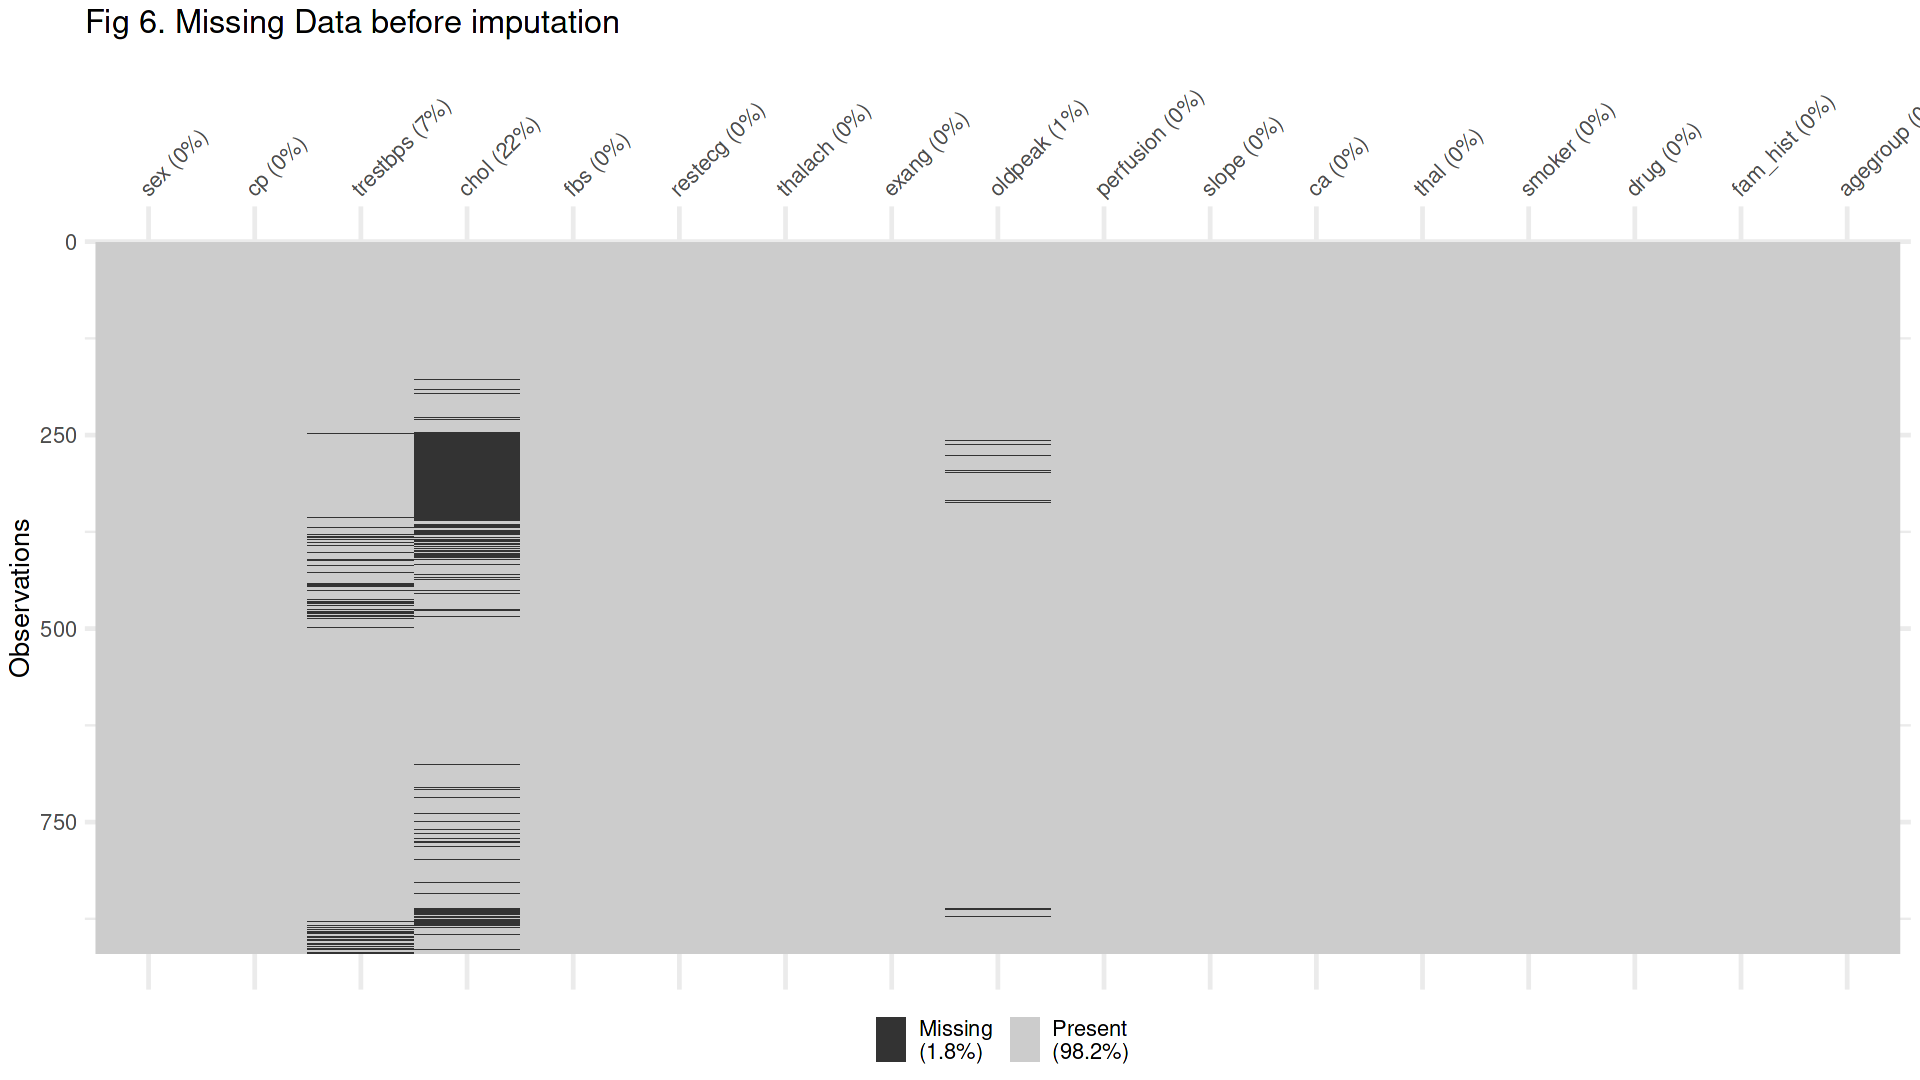

In [32]:
dataset_modified %>%                   # identify the missing values in the dataset for all columns
    select(-one_of(target_column)) %>%
    vis_miss()  +                      # Result: missing data in trestbps, chol, oldpeak
    labs(title="Fig 6. Missing Data before imputation") +
    theme(text = element_text(size = 16), element_line(size = 1))


 iter imp variable
  1   1  trestbps  chol  oldpeak
  1   2  trestbps  chol  oldpeak
  1   3  trestbps  chol  oldpeak
  1   4  trestbps  chol  oldpeak
  1   5  trestbps  chol  oldpeak
  2   1  trestbps  chol  oldpeak
  2   2  trestbps  chol  oldpeak
  2   3  trestbps  chol  oldpeak
  2   4  trestbps  chol  oldpeak
  2   5  trestbps  chol  oldpeak
  3   1  trestbps  chol  oldpeak
  3   2  trestbps  chol  oldpeak
  3   3  trestbps  chol  oldpeak
  3   4  trestbps  chol  oldpeak
  3   5  trestbps  chol  oldpeak
  4   1  trestbps  chol  oldpeak
  4   2  trestbps  chol  oldpeak
  4   3  trestbps  chol  oldpeak
  4   4  trestbps  chol  oldpeak
  4   5  trestbps  chol  oldpeak
  5   1  trestbps  chol  oldpeak
  5   2  trestbps  chol  oldpeak
  5   3  trestbps  chol  oldpeak
  5   4  trestbps  chol  oldpeak
  5   5  trestbps  chol  oldpeak


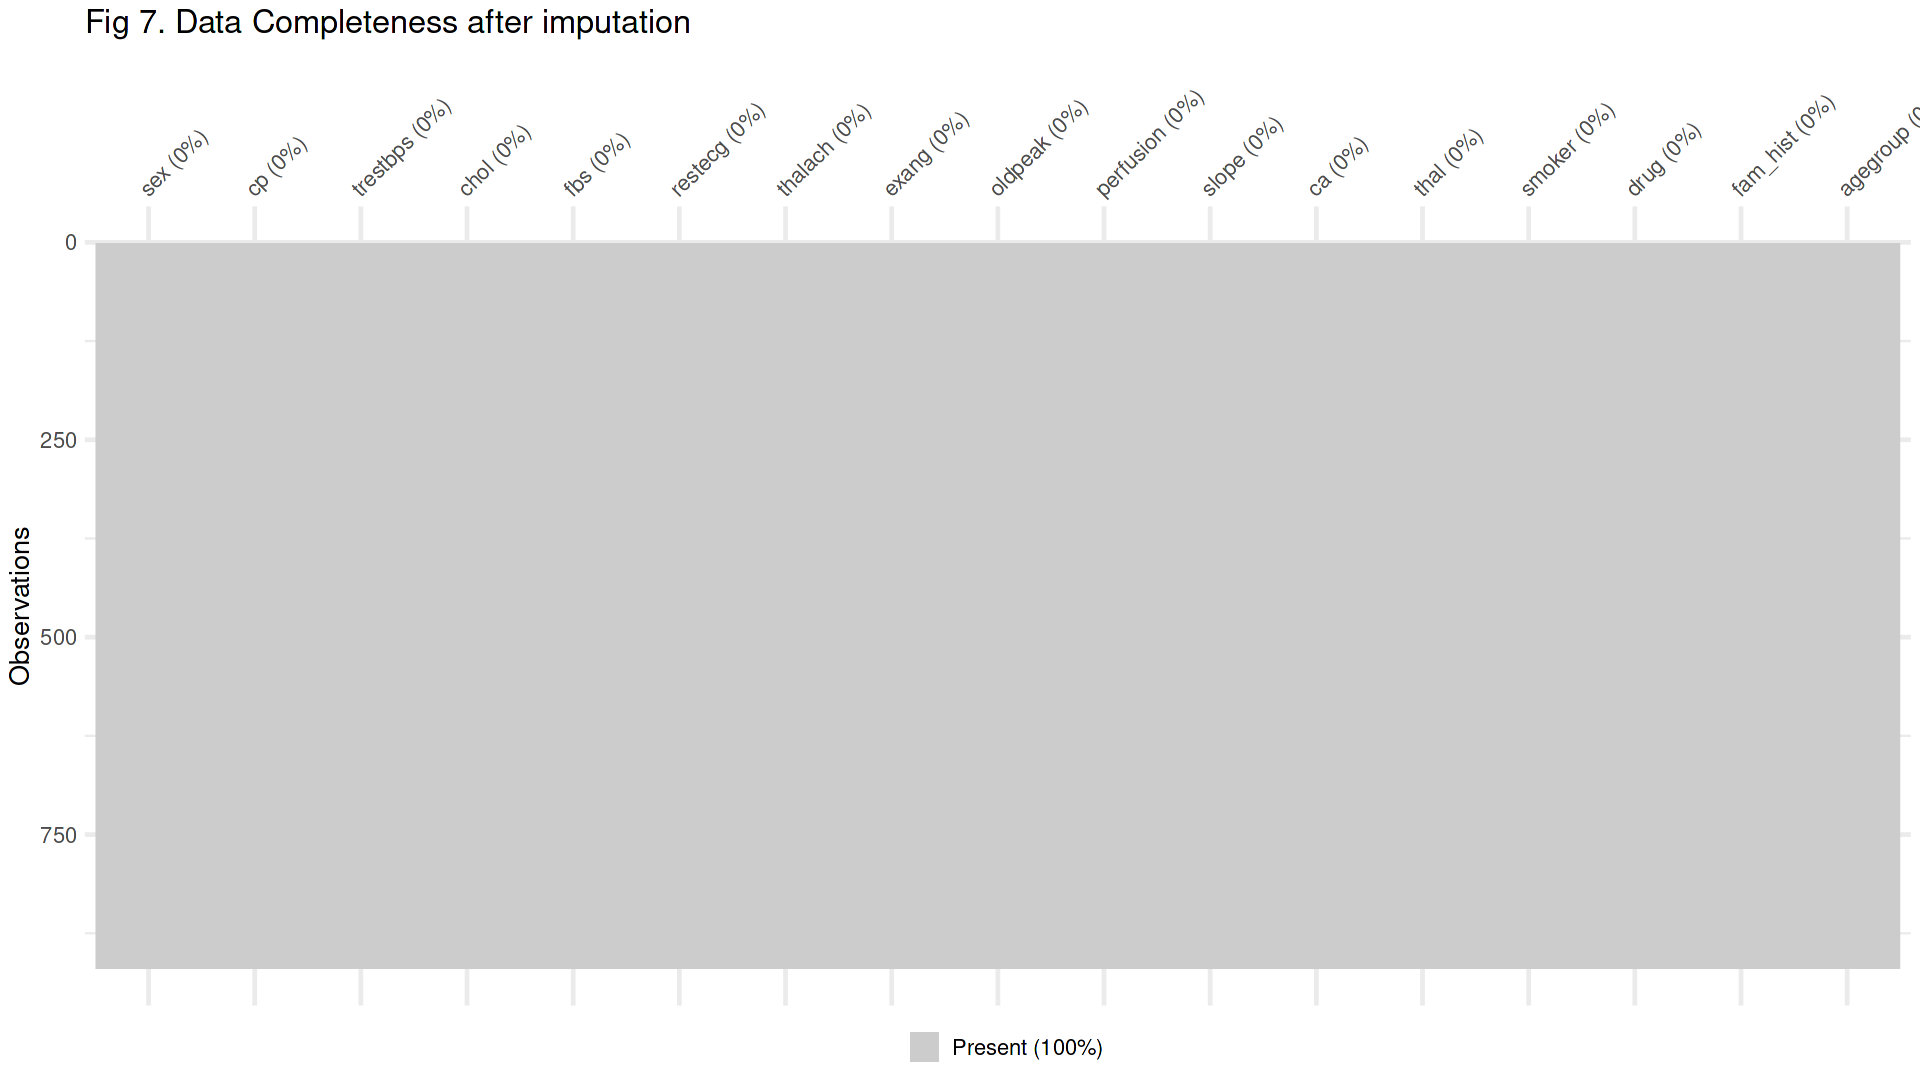

In [33]:
dataset_imputed <- mice(dataset_modified)         # multivariate imputation by chained equation, using the defaultmethod as per the column type
dataset_imputed <- complete(dataset_imputed)
dataset_imputed %>%                               # identify the missing values in the dataset for all columns
    select(-one_of(target_column)) %>%
    vis_miss() +                                   # Result: no missing data found
    labs(title="Fig 7. Data Completeness after imputation") +
    theme(text = element_text(size = 16), element_line(size = 1))

In [34]:
glimpse(dataset_imputed)

Rows: 920
Columns: 18
$ sex       <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, …
$ cp        <fct> 4, 4, 4, 4, 4, 3, 2, 2, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, …
$ trestbps  <dbl> 160, 120, 140, 130, 140, 130, 110, 120, 132, 130, 110, 117, …
$ chol      <dbl> 286, 229, 268, 254, 203, 256, 229, 284, 224, 206, 167, 230, …
$ fbs       <fct> 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, …
$ restecg   <fct> 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, …
$ thalach   <dbl> 108, 129, 160, 147, 155, 142, 168, 160, 173, 132, 114, 160, …
$ exang     <fct> 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, …
$ oldpeak   <dbl> 1.5, 2.6, 3.6, 1.4, 3.1, 0.6, 1.0, 1.8, 3.2, 2.4, 2.0, 1.4, …
$ perfusion <dbl> 0.477572922, 0.780928415, 0.608129542, 0.176835867, -0.08584…
$ slope     <fct> 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, …
$ ca        <dbl> 3, 2, 2, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 3, 0, 1, 0, …
$ thal      <fct> 

**Train-Test Split**

> - Splitting the data into Train and Test sets, where the train set is used for training the model and test set is used for validating the model performance. The validation metrics are then used to compare with other models and the models with better validation metrics are selected.
> - Since the dataset size is smaller, the split here considered is a `stratified 80-20 train-test split` respectively. If the size of the dataset was even larger, the dataset could have been split into train - validation - test sets, where test ( hold out set ) could be used for reporting the final model performance.
> - Splitting from training set, does not necessarily provide true model performance as the dataset is split from the same distribution. Inorder to get the true model performance an holdout set from another distribution is required which is out of scope for this experiment.


[(5)](#reference)

In [35]:
train_test_split_data <- function(data){
    #' @description 
    #' A function to split the dataset into train and test using the K-fold crossvalidation method.
    #' 
    #' @param data, the data to be split
    #'
    #' @example 
    #'  split_data <- train_test_split_data(data)
    #' 
    #' 
    #' @return split_data, named list containing the train and test dataset
    
    # create a new row idx to ensure the split is happening
    data <- data %>%
        mutate(row_idx=row_number())
    
    # stratify the dataset as per class, 80% training and 20% testing
    train_dataset <- stratified(data, c('class'), 0.8)
    
    # create the test dataset by excluding  the row indexes included in the train dataset
    test_dataset <- data %>%
        filter(!row_idx %in% train_dataset[["row_idx"]])
    
    split_data <- list(train=train_dataset, test=test_dataset)
    # plot and check if the class has equal / almost equal representation of the class
    # rechecking the distribution of class in train dataset
    
    for(dataset_name in c("train", "test")){
        # remove the row index
        split_data[[dataset_name]] <- split_data[[dataset_name]] %>%
            select(-row_idx)
        
        # plot the class distribution
        plt <- ggplot(data=split_data[[dataset_name]], aes(x=class)) +
                 geom_histogram(stat="count") +
                 labs(title=dataset_name) +
                 theme(text = element_text(size = 16), element_line(size = 1))
        
        print(plt)
    
    }
    
    return(split_data)
}

## Logistic Regression  <a class="anchor"  id="logreg"></a>[↑](#top)

<hr/>
  
  > - `Multiple Logistic Regression` is used to predict binary response.
  > - MLR model forms a linear combination of predictors in the logistic equation, that helps understand the combination of predictors that has high effect on the outcome.
  > - $f(Y) = { e^{\beta_0X_0 + \beta_1X_1 + ... + \beta_PX_P} \over {1 + e^{\beta_0X_0 + \beta_1X_1 + ... + \beta_PX_P}}}$ Equation shows the logistic function with `Y` as outcome that is logistic function and linear combination of coefficients ( learned weights ) and `P` predictor  variables. 
  > - This model was selected due to its simple to intrepret.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


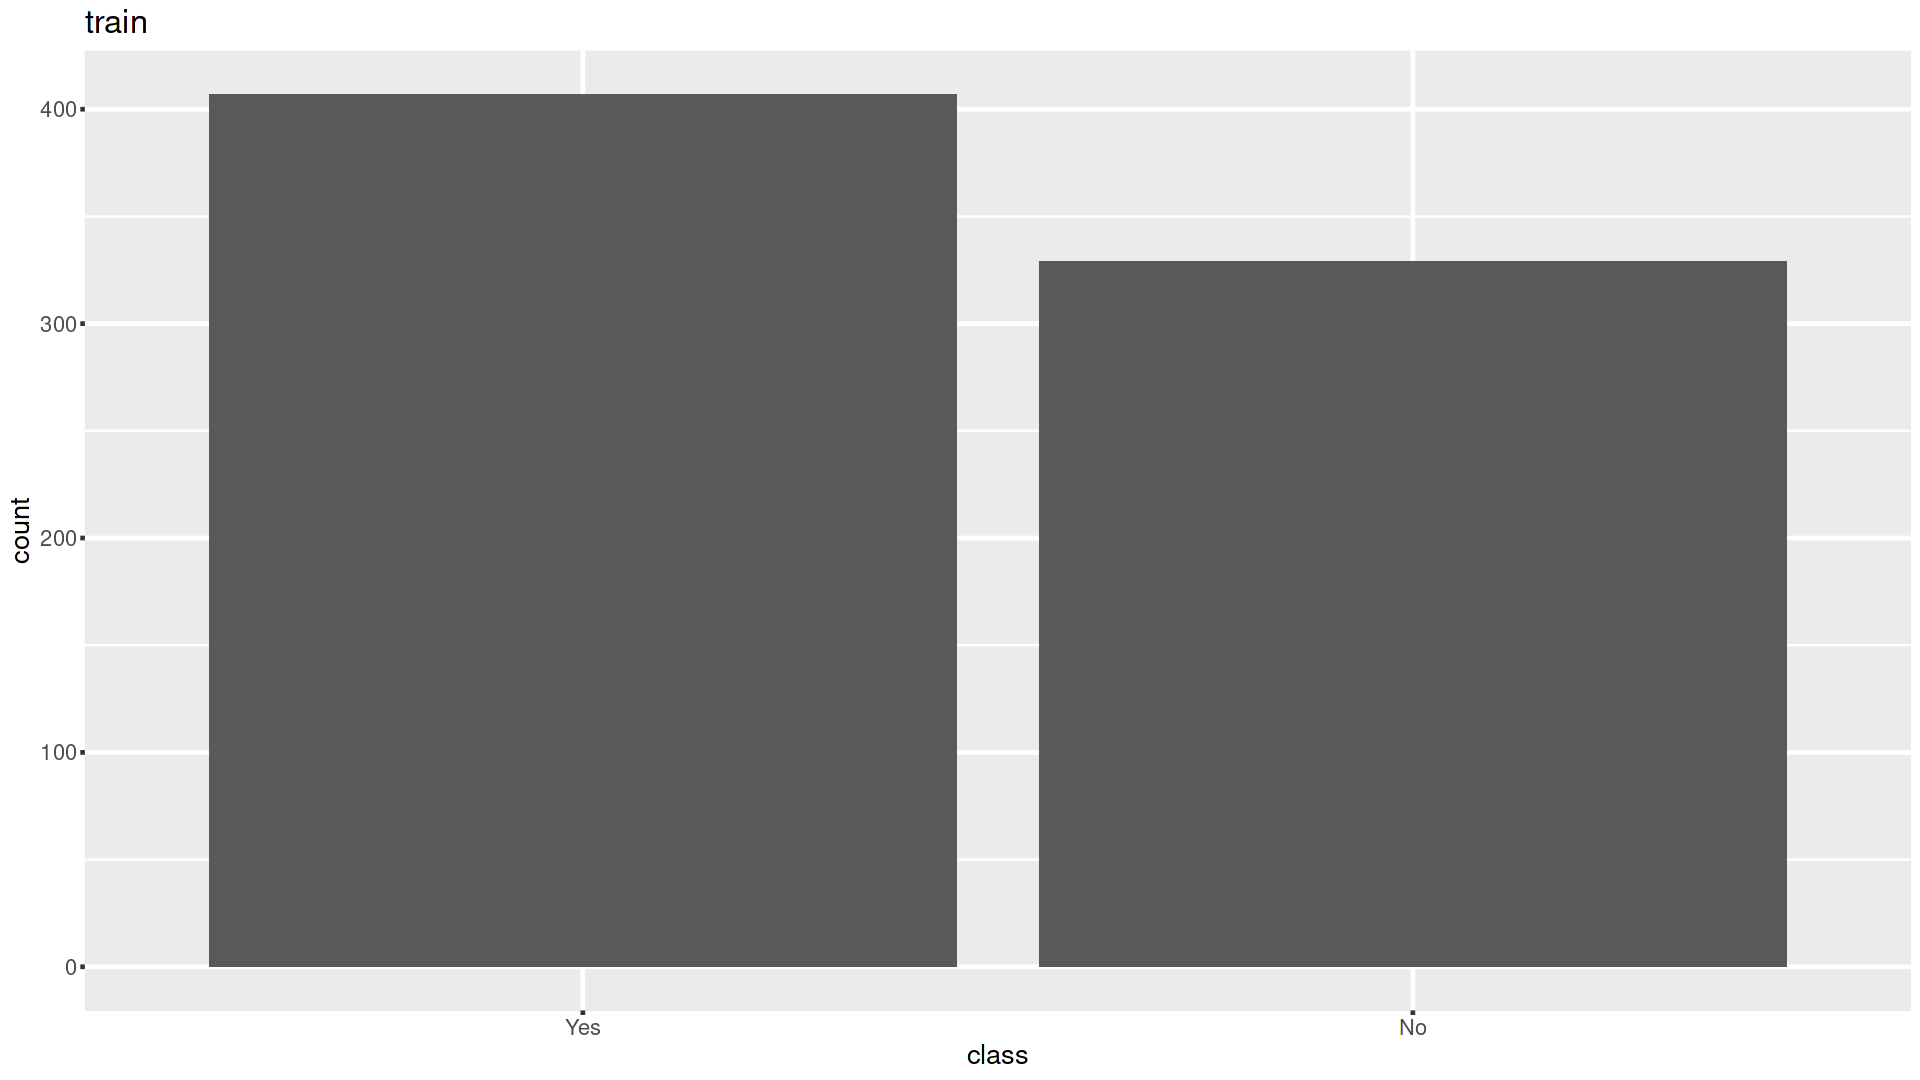

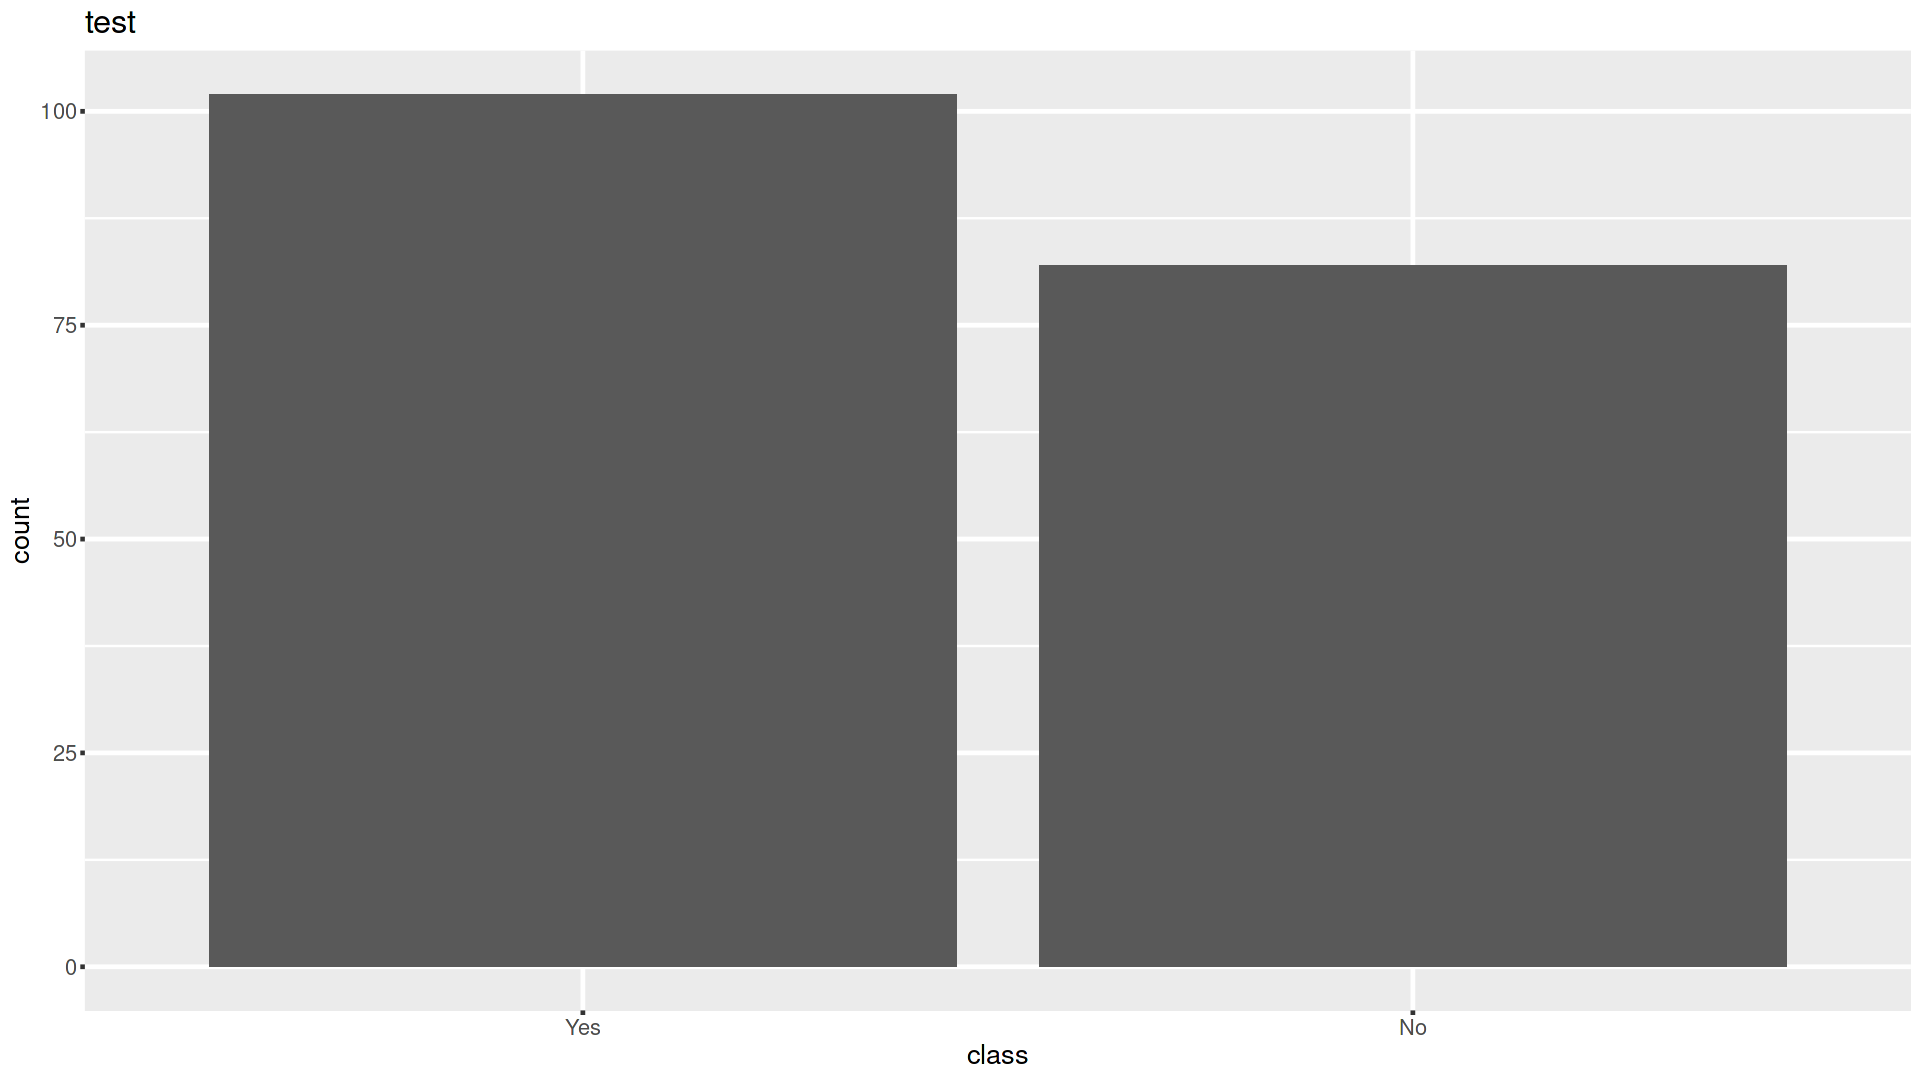

In [36]:
split_data <- train_test_split_data(dataset_imputed)
train_dataset <- split_data[["train"]]
test_dataset <- split_data[["test"]]

**K-fold cross validation**

> - The value of K = 5, with R = 3 repeats is selected for Repeated K-fold cross validation.
> - Repeated Cross Validation is used to obtain robust results, as it simply applies the cross validation R repeat times, with each repeat splitting the data differently.

In [37]:
# building  a k fold cross validation logistic regression model

folds <- 5                                                                  # number of folds to be created
repeats <- 3                                                                # number of times to repeat the cross validation
cvIndex <- createFolds(train_dataset$class, folds, returnTrain = T)         # indexes of each folds

#  train control for the model
ctrl <- trainControl(  
    index = cvIndex, 
    method = 'repeatedcv', 
    number = folds,
    repeats=repeats,
    search = 'grid',                                                        # grid search method is selected for CV
    classProbs = TRUE,
    summaryFunction = twoClassSummary                                       # required for ROC metric to be used as metric for selecting models
)        

log_reg_model <- train(                                                     # train the model
    class ~ .,
    data=train_dataset, 
    method="glm", 
    family="binomial", 
    metric="ROC",
    trControl=ctrl
)

print(log_reg_model)

Generalized Linear Model 

736 samples
 17 predictor
  2 classes: 'Yes', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 589, 588, 589, 590, 588 
Resampling results:

  ROC        Sens      Spec    
  0.8858833  0.852695  0.787366



In [38]:
# to check the most significant variables
summary(log_reg_model)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4714  -0.5474  -0.2042   0.5127   2.6448  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      3.8056803  1.6159705   2.355 0.018521 *  
sex1            -1.1390033  0.2982589  -3.819 0.000134 ***
cp2              0.4135436  0.5220767   0.792 0.428295    
cp3             -0.3826500  0.4905326  -0.780 0.435349    
cp4             -1.8098597  0.4703515  -3.848 0.000119 ***
trestbps         0.0009578  0.0061541   0.156 0.876314    
chol            -0.0032210  0.0020872  -1.543 0.122783    
fbs1            -0.3453201  0.3238712  -1.066 0.286321    
restecg1        -0.1108999  0.2973364  -0.373 0.709165    
restecg2         0.2794663  0.3085397   0.906 0.365057    
thalach          0.0044484  0.0029321   1.517 0.129230    
exang1          -0.9945005  0.2491193  -3.992 6.55e-05 ***
oldpeak         -0.6061416  0.1325720  -4.572 4.83e-06 ***
perfusion        0.0742107  0.218

**Significant Features**

> - `sex1`: sex[Male=1] CVD amongst males are more prevalent than women worldwide. [(6)](#reference)
> - `cp4`: Chestpain[cp=4 | Asymptotic] 
> - `chol`: High levels of bad cholestrol poses high risk for heart disease, [(7)](#reference)
> - `thalach`: Higher heart rate has high predictive power for heart disease. [(10)](#reference)
> - `exang1`: exang[1 | exercise induced angina]
> - `oldpeak`: ST Depression has some prediction power to heart disease [(9)](#reference)
> - `slope2`: slope[slope=2 | flat] does not make sense, that flat slope could lead to heart disease.
> - `ca`: number of major vessels plays a role in heart disease
> - `thala6`: thal[thal=6 | fixed defect] fixed defect thalassemia have high risk of having a heart disease. [(8)](#reference)
> - `thala7`: thal[thal=7 | reverseable defect] reversable defect thalassemia have medium - high risk of having a heart disease. [(8)](#reference)

### Performance Evaluation  <a class="anchor"  id="logreg_perf"></a>[↑](#top)

**Confusion Matrix**

> - A contingency table of `Predicted vs Actual` values, a method to evaluate model performance.

In [39]:
display_confusion_matrix <- function(model, data, positive="Yes"){
    #' @description 
    #' A function to produce the predicted class and probabilities, display the confusion metrics
    #' 
    #' @param model, the model to be evaluated
    #' @param data, test dataset to be used for evaluation
    #'
    #' @example 
    #'  split_data <- perf_eval(model, data)
    #' 
    #' 
    #' @return pred_df, predicted dataframe
    
    # creates a dataframe with actual and predicted class side by side
    pred_df <- data.frame()
    class <- predict(model, data %>% select(-class), type="raw")     # make class predictions
    probs <- predict(model, data %>% select(-class), type="prob")    # make probability predictions
    pred_df <- cbind(data$class, class, probs)
    names(pred_df)[1] <- "actual_class"
    names(pred_df)[2] <- "predicted_class"
    names(pred_df)[3] <- "proba_0"
    names(pred_df)[4] <- "proba_1"

    # display the confusion matrix
    cm <- confusionMatrix(pred_df$actual_class, pred_df$predicted_class, positive = positive)
    print(cm)
    return(pred_df)
}

In [40]:
pred_df_log_reg <- display_confusion_matrix(log_reg_model, test_dataset)

Confusion Matrix and Statistics

          Reference
Prediction Yes No
       Yes  85 17
       No   15 67
                                          
               Accuracy : 0.8261          
                 95% CI : (0.7634, 0.8779)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : 6.07e-16        
                                          
                  Kappa : 0.6489          
                                          
 Mcnemar's Test P-Value : 0.8597          
                                          
            Sensitivity : 0.8500          
            Specificity : 0.7976          
         Pos Pred Value : 0.8333          
         Neg Pred Value : 0.8171          
             Prevalence : 0.5435          
         Detection Rate : 0.4620          
   Detection Prevalence : 0.5543          
      Balanced Accuracy : 0.8238          
                                          
       'Positive' Class : Yes             
                                 

**Confusion Matrix Description**
> - 17 / 102, `false positives` are predicted by the model
> - `Accuracy > NIR` value, stating that the model has captured information and the p-value [Acc > NIR] states that the `difference is significant`.
> - `Mcnemar's test` states that the model there is no significant difference between the false positives and false negatives, indicating the `bias` in the model.
> - `Sensitivity / Recall` of the model is 0.85
> - `Pos Pred Value / Precision` of the model is 0.83

## Random Forest  <a class="anchor"  id="rf"></a>[↑](#top)

<hr/>
  
> - `Random forest` is an `ensemble` technique where multiple weak learners ( decision tree ) are combined ( ensembled ) to form a strong learner.
> - RF implements bagging or bootstrap aggregating.
> - **Bagging** is performed as a bootstrap sample $b_{[1-B]}$ with replacement is created from the dataset, where $B$ is the number of bootstrap samples to be created. Then, models $m_{[1-M]}$ are trained on each bootstrap samples such that, Predctions $P = ({1 \over M}) * (p[1] + p[2] + ... + p[m])$ where $p$ is the prediction from each model $m$.
> - Random Forest is `good at handling outliers, sparse feature space and noisy data` as well.

In [41]:
rf_model <- train(
    class~., 
    data=train_dataset, 
    method='rf',
    ntree=200,
    metric="ROC",
    trControl=ctrl)   # same train control method is used for consistency sake
print(rf_model)

Random Forest 

736 samples
 17 predictor
  2 classes: 'Yes', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 589, 588, 589, 590, 588 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   2    0.8951398  0.8845528  0.7327739
  15    0.8750949  0.8624511  0.7477855
  28    0.8667007  0.8625113  0.7599068

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


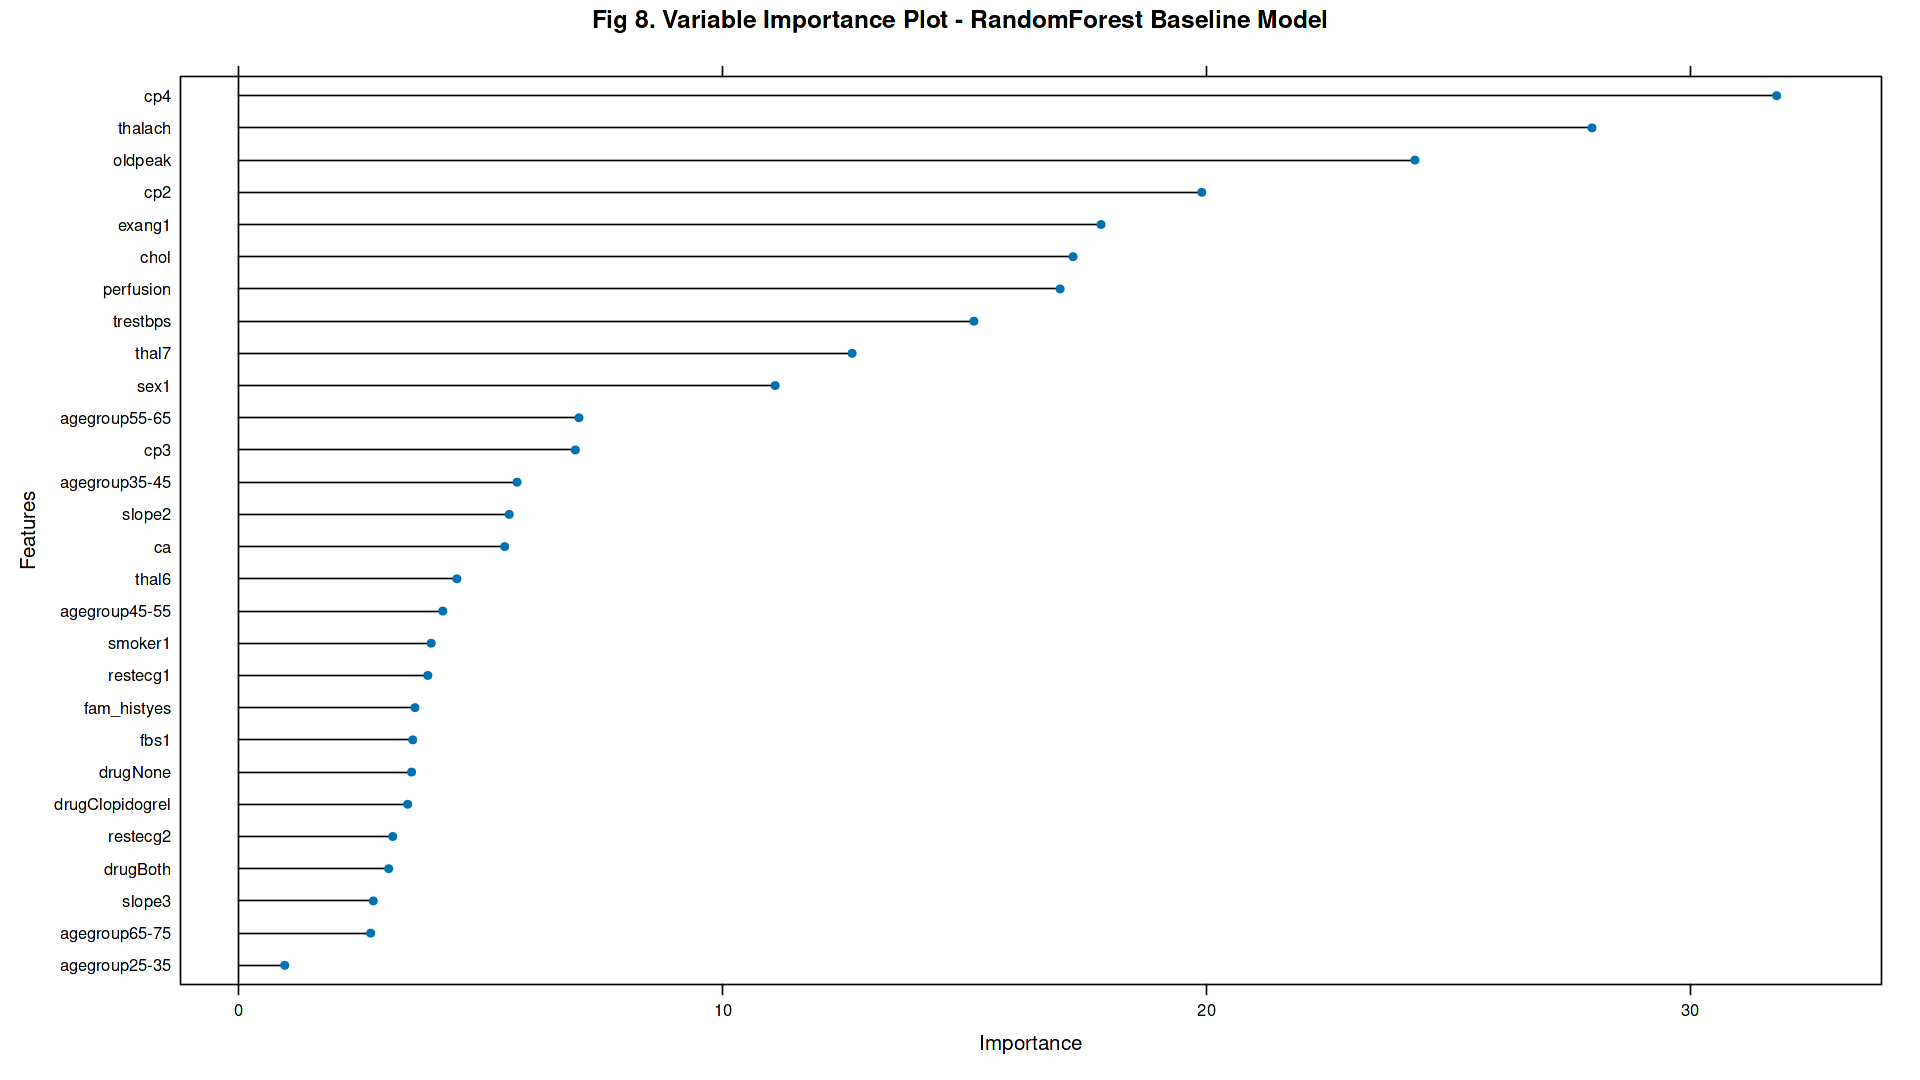

In [42]:
rf_model_var_imp <- varImp(rf_model, scale = FALSE)  # Feature importance from random forest
plot(rf_model_var_imp, main = "Fig 8. Variable Importance Plot - RandomForest Baseline Model", xlab="Importance", ylab="Features")

### Performance Evaluation  <a class="anchor"  id="rf_perf"></a>[↑](#top)

In [43]:
pred_df_rf <- display_confusion_matrix(rf_model, test_dataset)

Confusion Matrix and Statistics

          Reference
Prediction Yes No
       Yes  89 13
       No   24 58
                                          
               Accuracy : 0.7989          
                 95% CI : (0.7336, 0.8543)
    No Information Rate : 0.6141          
    P-Value [Acc > NIR] : 5.741e-08       
                                          
                  Kappa : 0.5876          
                                          
 Mcnemar's Test P-Value : 0.1002          
                                          
            Sensitivity : 0.7876          
            Specificity : 0.8169          
         Pos Pred Value : 0.8725          
         Neg Pred Value : 0.7073          
             Prevalence : 0.6141          
         Detection Rate : 0.4837          
   Detection Prevalence : 0.5543          
      Balanced Accuracy : 0.8023          
                                          
       'Positive' Class : Yes             
                                 

**Confusion Matrix Description**
> - 13 / 102, `false positives` are predicted by the model, comparatively less than logistic regression model.
> - `Accuracy > NIR` value, stating that the model has captured information and the p-value [Acc > NIR] states that the `difference is significant`.
> - `Mcnemar's test` states that the model there is no significant difference between the false positives and false negatives, indicating the `bias` in the model. `However` the bias in the model is lesser than logistic regression.
> - `Sensitivity / Recall` of the model is 0.78
> - `Pos Pred Value / Precision` of the model is 0.87

In [44]:
rf_model[[11]]


Call:
 randomForest(x = x, y = y, ntree = 200, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 2

        OOB estimate of  error rate: 20.11%
Confusion matrix:
    Yes  No class.error
Yes 350  57   0.1400491
No   91 238   0.2765957

> - The `OOB` out of bag error estimate is 20.11%, this would be useful when comparing with the hyptertuned model. the lower the error estimate the better

## ROC Analysis  <a class="anchor"  id="roc"></a>[↑](#top)

<hr/>

In [45]:
pred_df_log_reg <- pred_df_log_reg %>%
    mutate(model_name="Logistic Regression")

pred_df_rf <- pred_df_rf %>%
    mutate(model_name="Random Forest")


pred_df <- rbind(pred_df_log_reg, pred_df_rf)

head(pred_df)

,actual_class,predicted_class,proba_0,proba_1,model_name
,<fct>,<fct>,<dbl>,<dbl>,<chr>
1,Yes,Yes,0.9166628,0.08333717,Logistic Regression
2,Yes,No,0.3039324,0.69606760,Logistic Regression
3,Yes,Yes,0.9724518,0.02754817,Logistic Regression
4,Yes,Yes,0.8864374,0.11356260,Logistic Regression
5,Yes,Yes,0.6124428,0.38755725,Logistic Regression
6,Yes,No,0.2432076,0.75679242,Logistic Regression


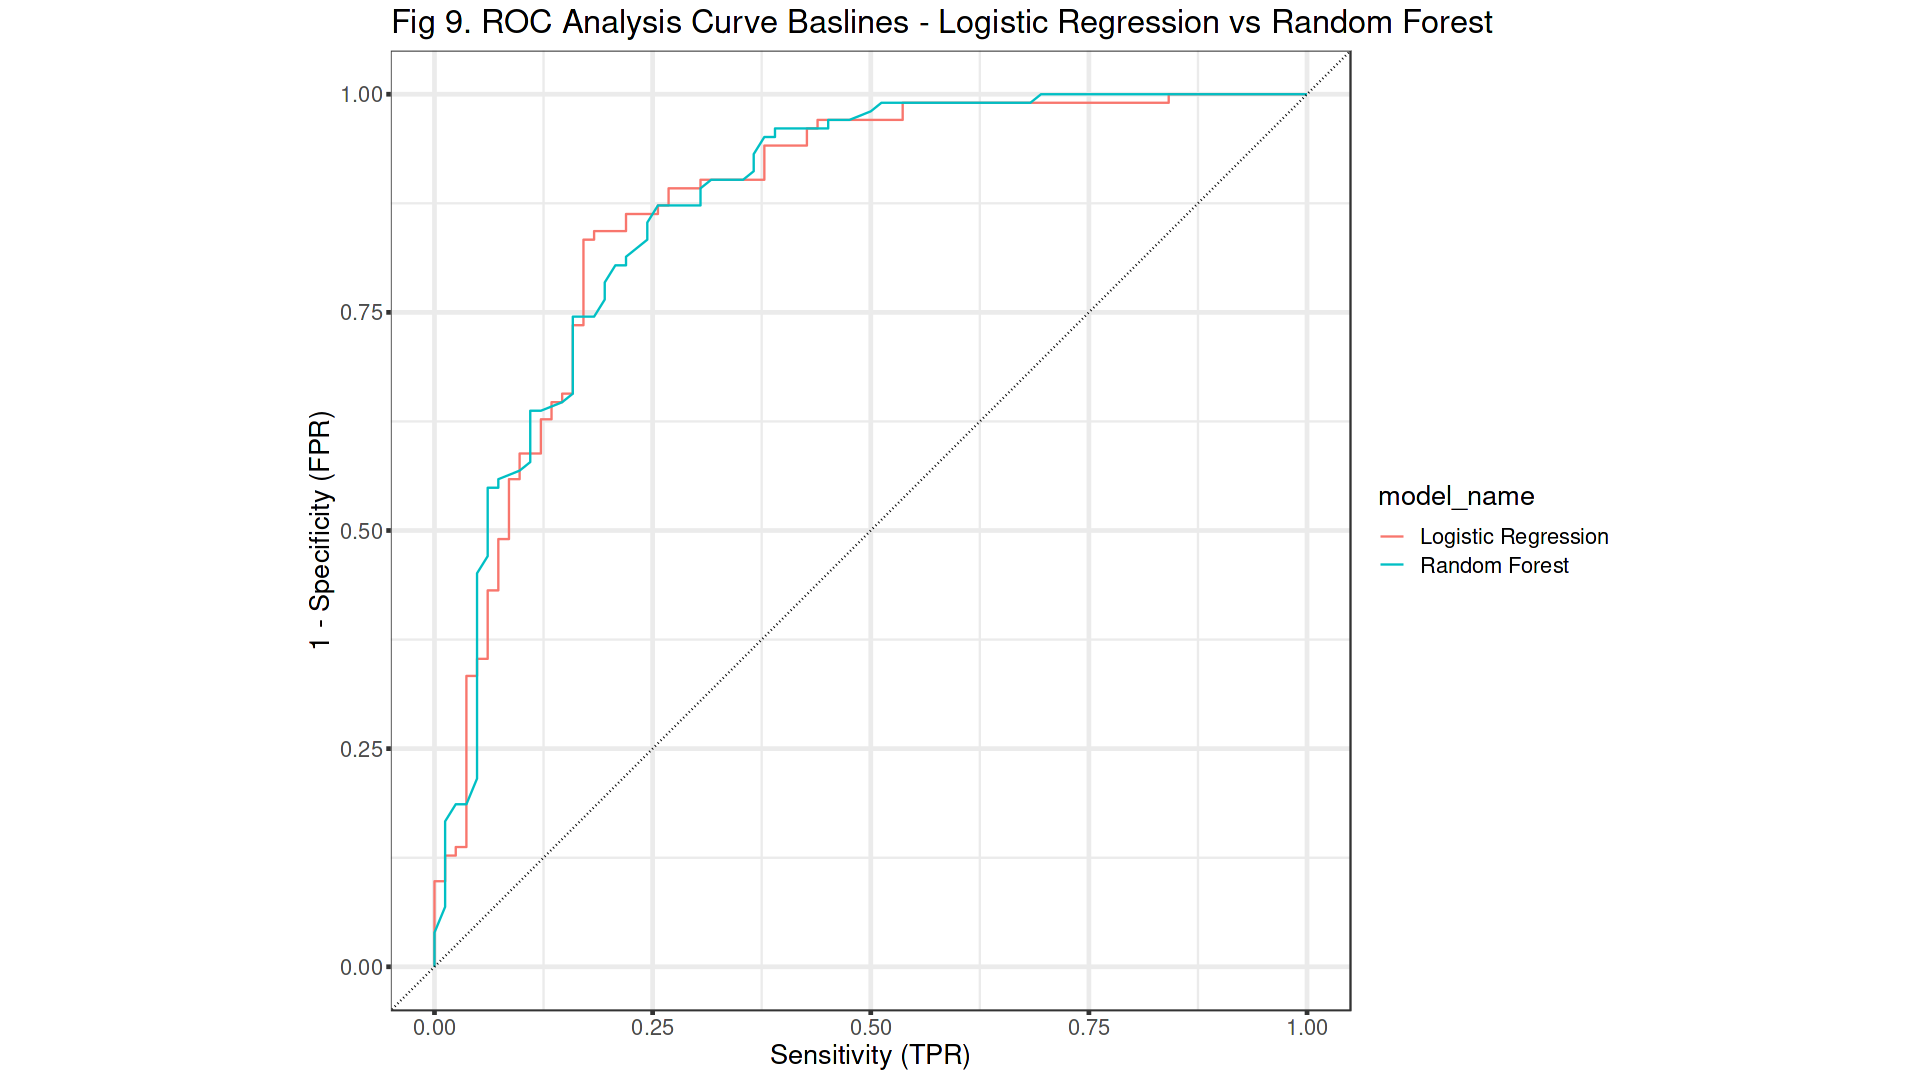

In [46]:
pred_df %>%
    group_by(model_name) %>%
    roc_curve(truth=actual_class, proba_0) %>%
    autoplot() +
    labs(title="Fig 9. ROC Analysis Curve Baslines - Logistic Regression vs Random Forest", x="Sensitivity (TPR)", y="1 - Specificity (FPR)") +
    theme(text = element_text(size = 16), element_line(size = 1))

> - `ROC analysis` shows that the Logistic Regression and Random Forest have almost the same sensitivity towards predicting the heart disease, but Random Forest has a `smoother` curve than the Logistic Regression.

## Random Forest: Hyperparameter Tuning  <a class="anchor"  id="rf_tune"></a>[↑](#top)
<hr/>

`Random Forest (RF) Classifier was selected over Logistic Regression (LR)` because of the following reasons:
  > + `Linearity and Non-Linearity both` can be explained by RF, but LR is restricted to Linearity
  > + RF has more `number of hyperparameters to tune` than LR, that makes it more capable to explore feature space inorder to model latent patterns.
  > + RF `handles outliers, noise and NA values` more robustly than LR
  > + `Singularity` does not affect RF.
  > + On comparison, in the confusion matrix report, `Mcnemar's Test P-Value RF < Mcnemar's Test P-Value LR`, which indicates that `LR model is more biased than the RF model`.
  > + The number of `false positives` is lower in RF than in LR.

**Hyperparameter Tuning** explained

> - Random Forest is a black box model, so hyperparameters needs to be optimized to inorder to achieve higher model performance.
> - `Repeated K fold cross validation` with K folds = 5 and repeats = 5, with ROC as metric use to select from the list of the models from the search grid.
> - `mtry` = 2 as it the best value from the baseline model
> - `ntree` = 200 is the best tree value from the baseline model, the number of trees increases by 50 uptil 1000 trees
> - The method implements a `grid search` of number of trees

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


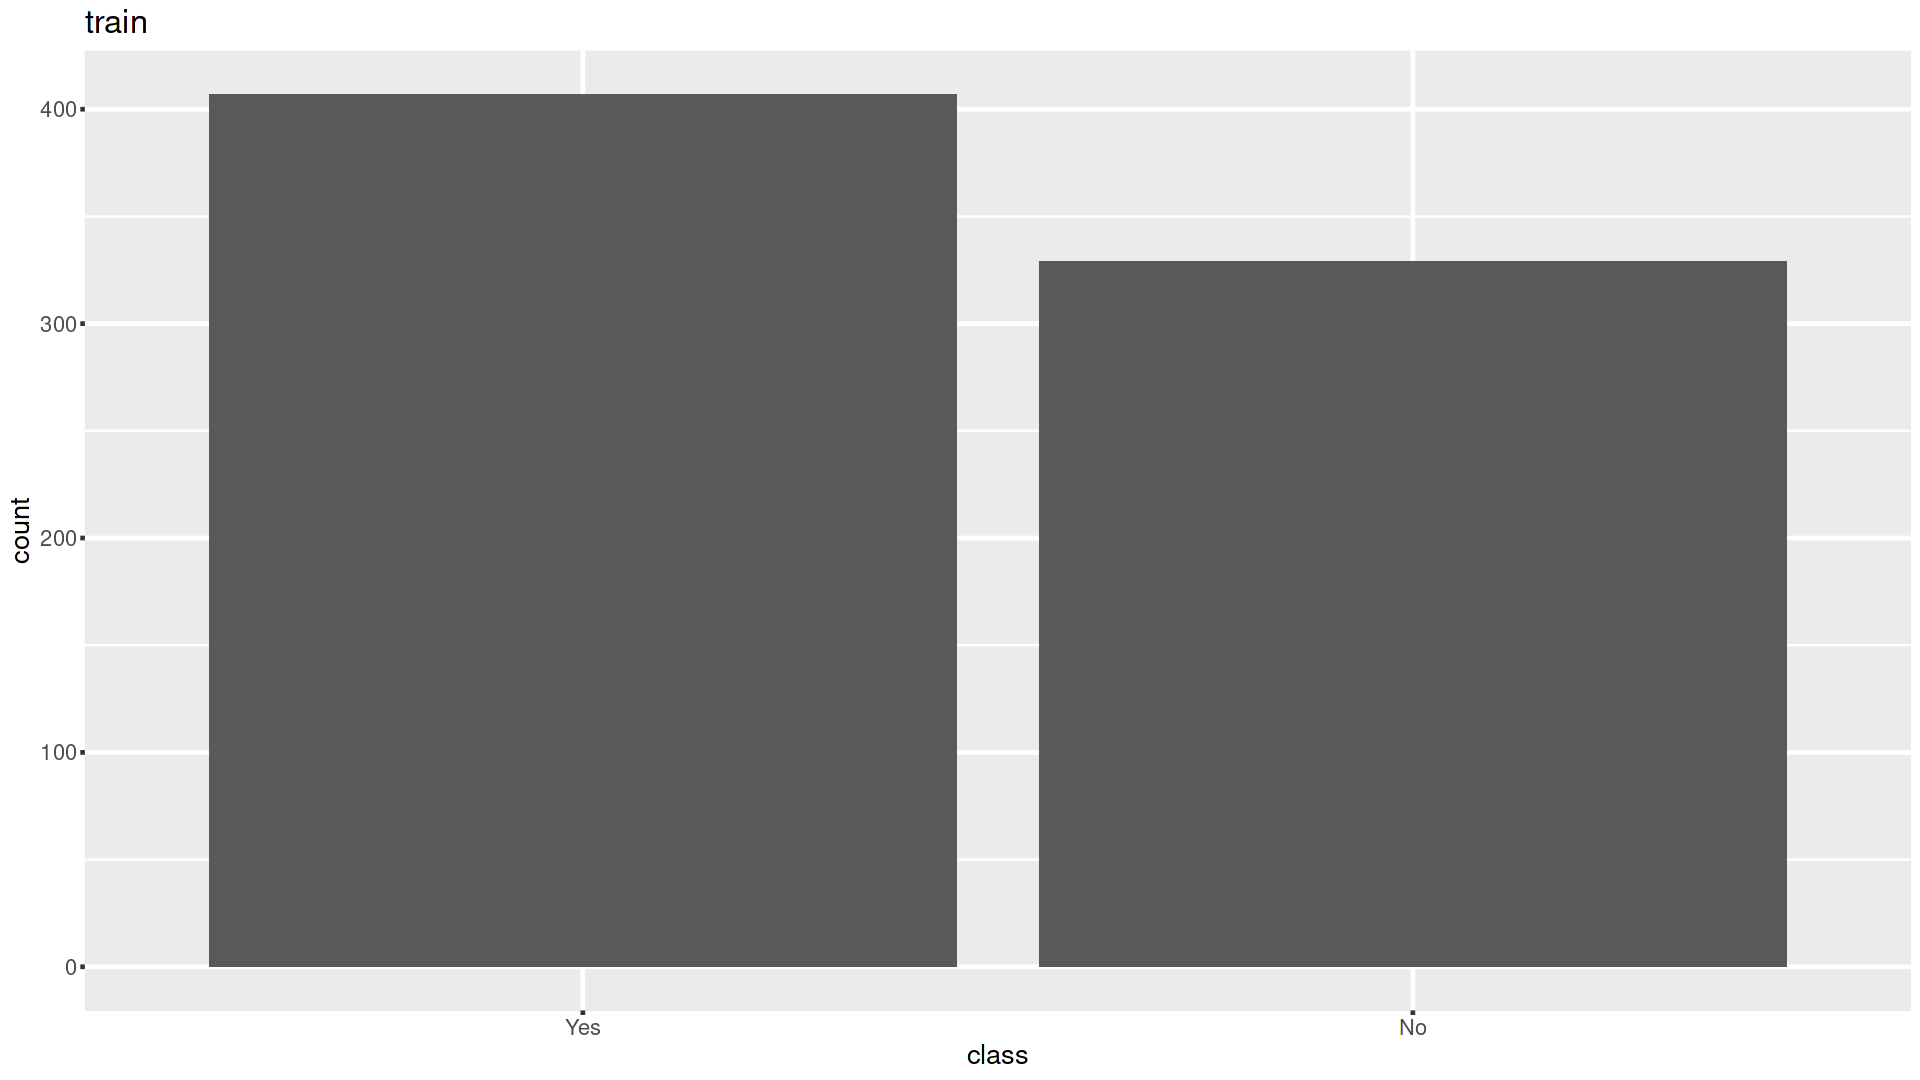


Call:
summary.resamples(object = results)

Models: 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000 
Number of resamples: 25 

ROC 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
200  0.8433396 0.8638234 0.8795361 0.8815494 0.9043792 0.9176019    0
250  0.8166854 0.8640105 0.8877666 0.8820908 0.9018893 0.9268293    0
300  0.8217636 0.8681257 0.8833707 0.8826708 0.8998316 0.9183286    0
350  0.8269586 0.8655069 0.8817443 0.8825805 0.9015152 0.9276608    0
400  0.8300599 0.8690872 0.8852550 0.8840110 0.9003141 0.9255461    0
450  0.8257576 0.8647450 0.8917379 0.8837957 0.9055802 0.9205469    0
500  0.8430602 0.8739837 0.8790650 0.8841838 0.9031781 0.9270483    0
550  0.8237935 0.8651146 0.8827605 0.8815092 0.9006648 0.9188840    0
600  0.8409307 0.8721474 0.8861789 0.8846300 0.9016144 0.9188178    0
650  0.8486719 0.8709350 0.8855322 0.8838499 0.8966186 0.9120838    0
700  0.8381968 0.8567073 0.8895872 0.8848241 0.9034188 0.9315

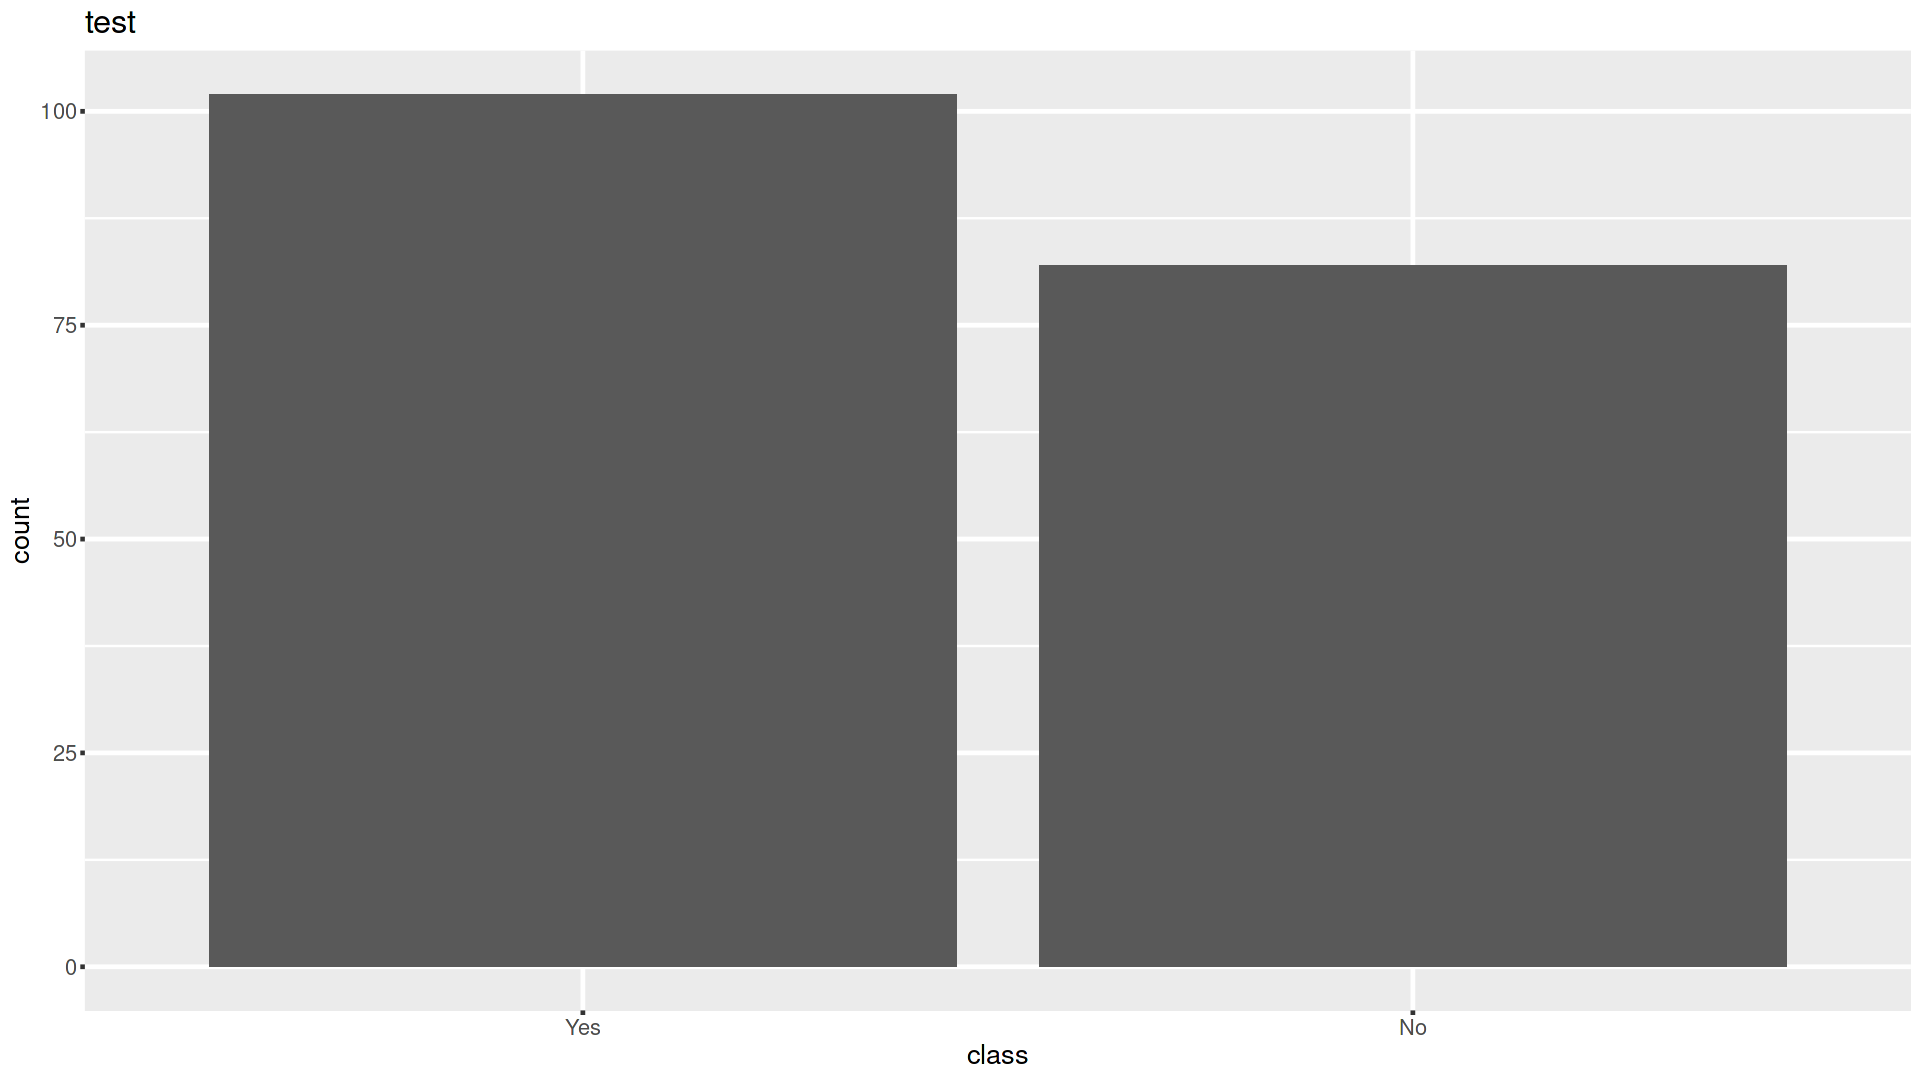

In [47]:
# split the dataset
hp_split_data <- train_test_split_data(dataset_imputed)
hp_train <- hp_split_data[['train']]
hp_test <- hp_split_data[['test']]


# setting the train control 
control <- trainControl(
    method = 'repeatedcv',    # to obtain more robust result, repeated cv method is selected
    number = 5,         
    repeats = 5,
    search = 'grid',          # grid search method is selected for CV
    classProbs = TRUE,
    summaryFunction = twoClassSummary
)         

# create tunegrid
tunegrid <- expand.grid(.mtry = c(2))           # mtry = 2 was the best obtained from training on default 
modellist <- list()

# train with different ntree parameters
for (ntree in seq(200, 1000, 50)){             # ntree = 200 was used in the training with default 
  fit <- train(
      class ~ .,
      data = hp_train,
      method = 'rf',
      metric = 'ROC',
      tuneGrid = tunegrid,
      trControl = control,
      ntree = ntree
  )
  key <- toString(ntree)
  modellist[[key]] <- fit
}

#Compare results
results <- resamples(modellist)
summary(results)

In [48]:
model_performances_data <- data.frame()

ntree_list <- seq(200, 1000, 50)
for(idx in seq(1, length(modellist), 1)){
    tmp <- modellist[[idx]][[4]]
    
    tmp <- tmp %>%
        mutate(ntree=ntree_list[[idx]])
    
    model_performances_data <- rbind(model_performances_data, tmp)
}

In [49]:
head(model_performances_data)

,mtry,ROC,Sens,Spec,ROCSD,SensSD,SpecSD,ntree
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.8815494,0.8766757,0.7143030,0.02167447,0.04059294,0.05123744,200
2,2,0.8820908,0.8673653,0.7222191,0.02946939,0.03034274,0.06014922,250
3,2,0.8826708,0.8717736,0.7270490,0.02310978,0.03540396,0.04925574,300
4,2,0.8825805,0.8717374,0.7203823,0.02399556,0.03024283,0.05296730,350
5,2,0.8840110,0.8726649,0.7222378,0.02508162,0.04080521,0.05165016,400
6,2,0.8837957,0.8795122,0.7203823,0.02775915,0.03246668,0.05506485,450


In [50]:
top5 <- model_performances_data %>%
    arrange(desc(ROC))
head(top5)

,mtry,ROC,Sens,Spec,ROCSD,SensSD,SpecSD,ntree
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.8858173,0.8712617,0.7252867,0.01844503,0.03495154,0.04069136,950
2,2,0.8849344,0.8697621,0.7259394,0.02763280,0.03052819,0.04788771,800
3,2,0.8848956,0.8717314,0.7211189,0.02281239,0.03916137,0.06310913,900
4,2,0.8848241,0.8726649,0.7167552,0.02940344,0.04684568,0.06716963,700
5,2,0.8848198,0.8747245,0.7234965,0.02217743,0.02958309,0.05680719,1000
6,2,0.8846300,0.8785607,0.7203636,0.02238266,0.03202619,0.05182916,600


In [51]:
plot_data <- model_performances_data %>%
    gather(key="Metric", value="score", -ntree)

head(plot_data)

,ntree,Metric,score
,<dbl>,<chr>,<dbl>
1,200,mtry,2
2,250,mtry,2
3,300,mtry,2
4,350,mtry,2
5,400,mtry,2
6,450,mtry,2


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


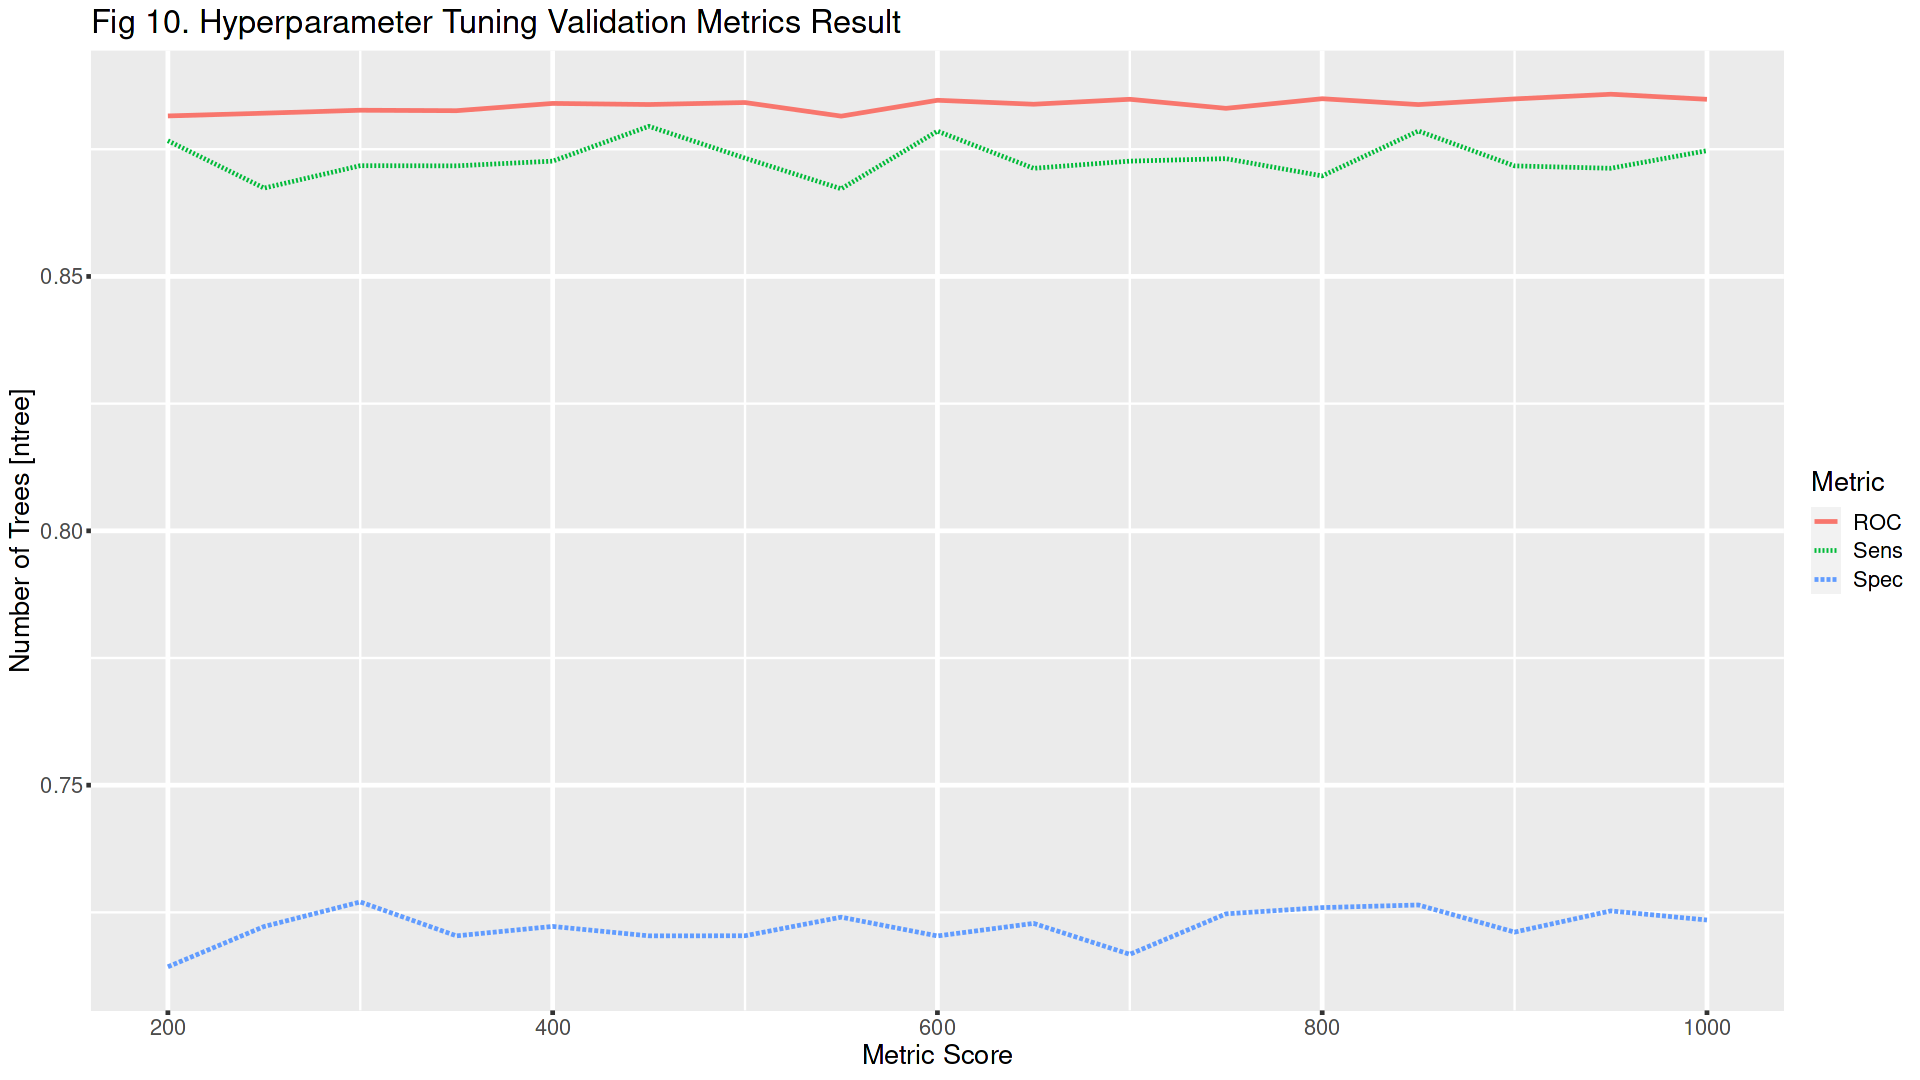

In [52]:
sample_data <- plot_data %>% filter(Metric %in% c("ROC", "Sens", "Spec"))
ggplot(data=sample_data, aes(x = ntree, y = score)) + 
  geom_line(aes(color = Metric, linetype = Metric), size=1) +
  theme(text = element_text(size = 16), element_line(size = 1)) + 
  labs(title="Fig 10. Hyperparameter Tuning Validation Metrics Result", x="Metric Score", y="Number of Trees [ntree]") +
  theme(text = element_text(size = 16), element_line(size = 1))

> - `ntree = 250` has one of the highest specificity, sensitivity and relatively small number of trees. thus the model is selected.

In [53]:
model_performances_data %>% filter(ntree == 250)

mtry,ROC,Sens,Spec,ROCSD,SensSD,SpecSD,ntree
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0.8820908,0.8673653,0.7222191,0.02946939,0.03034274,0.06014922,250


In [54]:
modellist[[2]]

Random Forest 

736 samples
 17 predictor
  2 classes: 'Yes', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 589, 589, 589, 588, 589, 589, ... 
Resampling results:

  ROC        Sens       Spec     
  0.8820908  0.8673653  0.7222191

Tuning parameter 'mtry' was held constant at a value of 2

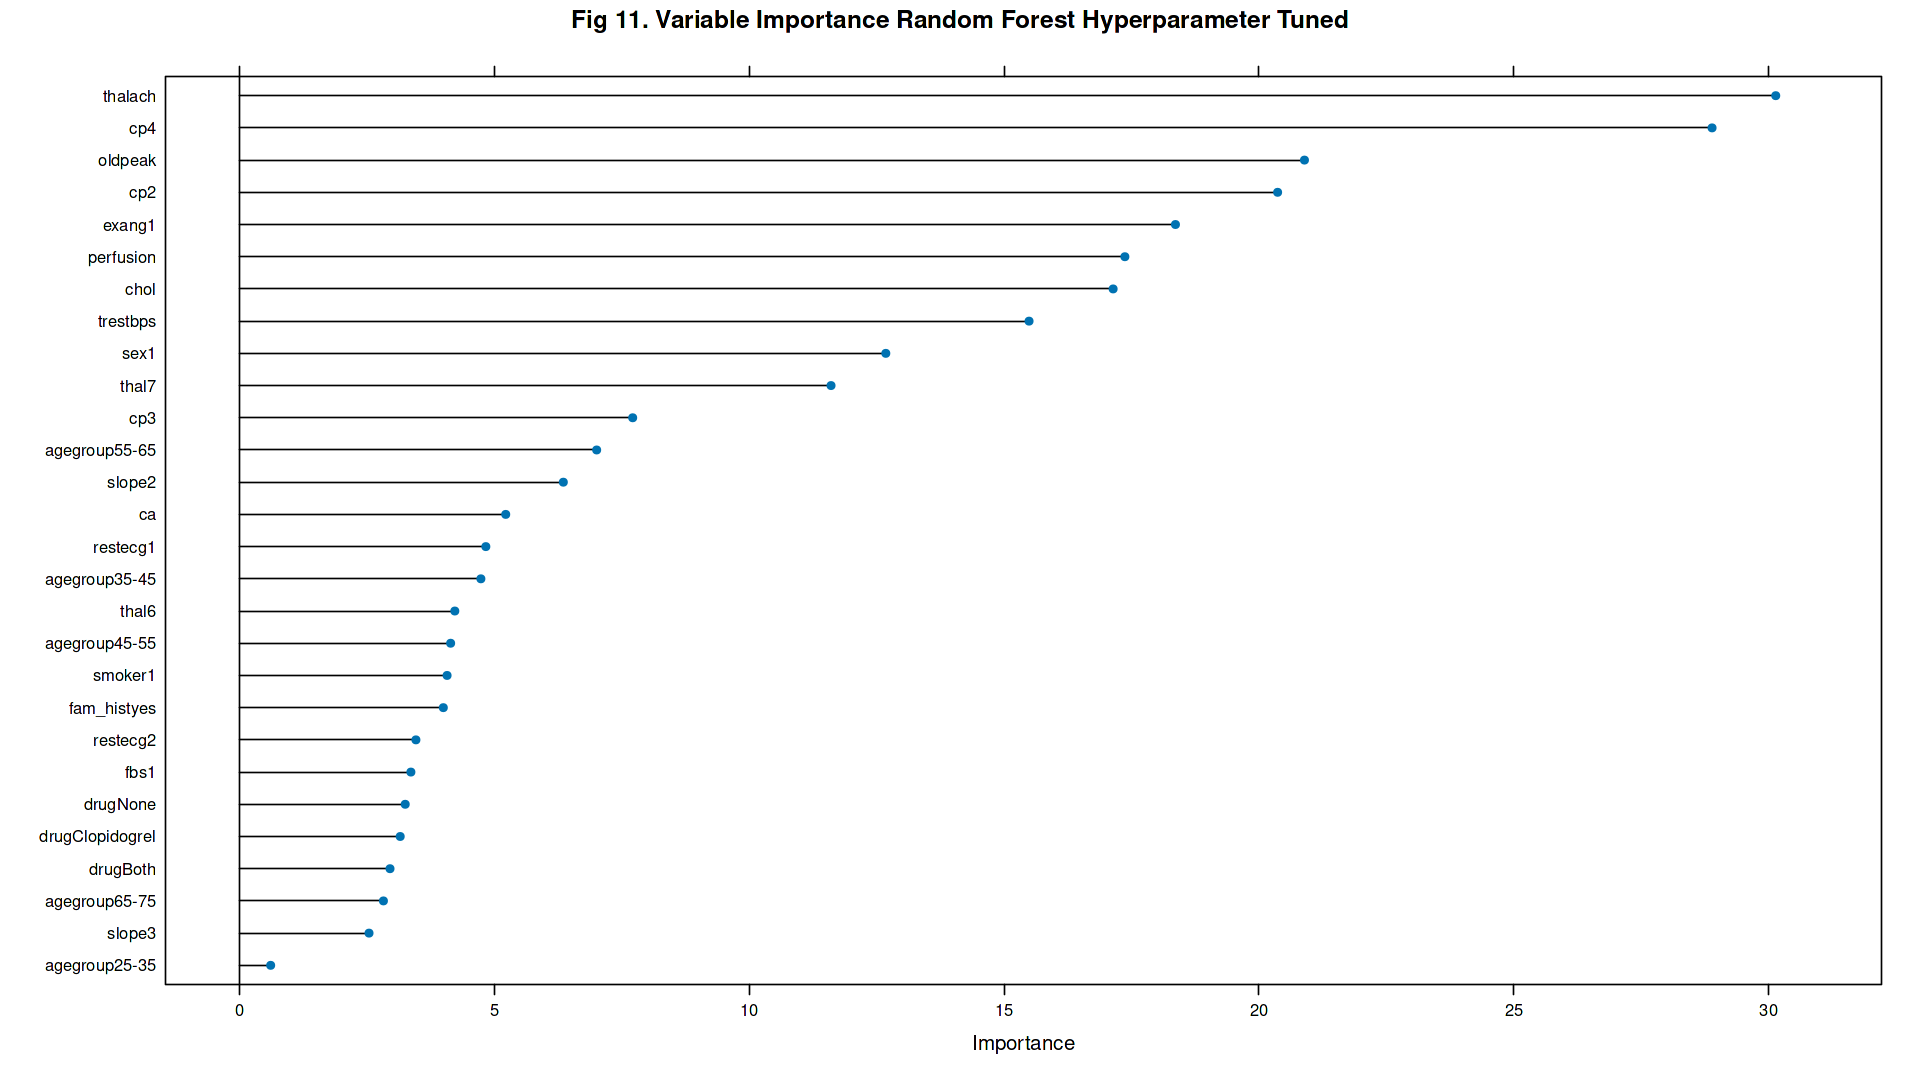

In [58]:
rf_model_var_imp_hp <- varImp(modellist[[2]], scale = FALSE) 
plot(rf_model_var_imp_hp, main="Fig 11. Variable Importance Random Forest Hyperparameter Tuned")

In [59]:
modellist[[2]][[11]]  # OOB error rate is reduced in comparison the baseline RF model


Call:
 randomForest(x = x, y = y, ntree = ..1, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 250
No. of variables tried at each split: 2

        OOB estimate of  error rate: 19.16%
Confusion matrix:
    Yes  No class.error
Yes 359  48   0.1179361
No   93 236   0.2826748

> - The out of bag error estimate is has improved `19.16% vs 20.11%` compared to the baseline model

In [65]:
hp_rf_pred_df <- display_confusion_matrix(modellist[[2]], hp_test)

Confusion Matrix and Statistics

          Reference
Prediction Yes No
       Yes  93  9
       No   19 63
                                          
               Accuracy : 0.8478          
                 95% CI : (0.7876, 0.8964)
    No Information Rate : 0.6087          
    P-Value [Acc > NIR] : 1.219e-12       
                                          
                  Kappa : 0.6883          
                                          
 Mcnemar's Test P-Value : 0.08897         
                                          
            Sensitivity : 0.8304          
            Specificity : 0.8750          
         Pos Pred Value : 0.9118          
         Neg Pred Value : 0.7683          
             Prevalence : 0.6087          
         Detection Rate : 0.5054          
   Detection Prevalence : 0.5543          
      Balanced Accuracy : 0.8527          
                                          
       'Positive' Class : Yes             
                                 

> - 9 / 102, `false positives` are predicted by the model, better than the baseline models.
> - `Accuracy > NIR` value, stating that the model has captured information and the p-value [Acc > NIR] states that the `difference is significant`.
> - `Mcnemar's test` states that the model there is no significant difference between the false positives and false negatives, indicating the `bias` in the model. `However` the bias in the model is much lesser than baseline models and closer to 0.05.
> - `Sensitivity / Recall` of the model is 0.83
> - `Pos Pred Value / Precision` of the model is 0.91

*Side note: is the model `overfitting`?*
> - Inorder to check if the model is really overfitting, more data is required for testing and analysis of the algorithm.
> - Small number of trees was selected bearing in mind that overfitting is to be traded off.
> - For comparison of model performance, the `class error rate` of the RF model has improved from `0.14 to 0.11` during repeatedCV when predicting Positive class.
> - This would state that the model has some bias in it, as confirmed by `Mcnemar's Test p-value`

In [61]:
hp_rf_pred_df <- hp_rf_pred_df %>%
    mutate(model_name="RF HyperTuned")
pred_df <- rbind(pred_df, hp_rf_pred_df)
head(pred_df)

,actual_class,predicted_class,proba_0,proba_1,model_name
,<fct>,<fct>,<dbl>,<dbl>,<chr>
1,Yes,Yes,0.9166628,0.08333717,Logistic Regression
2,Yes,No,0.3039324,0.69606760,Logistic Regression
3,Yes,Yes,0.9724518,0.02754817,Logistic Regression
4,Yes,Yes,0.8864374,0.11356260,Logistic Regression
5,Yes,Yes,0.6124428,0.38755725,Logistic Regression
6,Yes,No,0.2432076,0.75679242,Logistic Regression


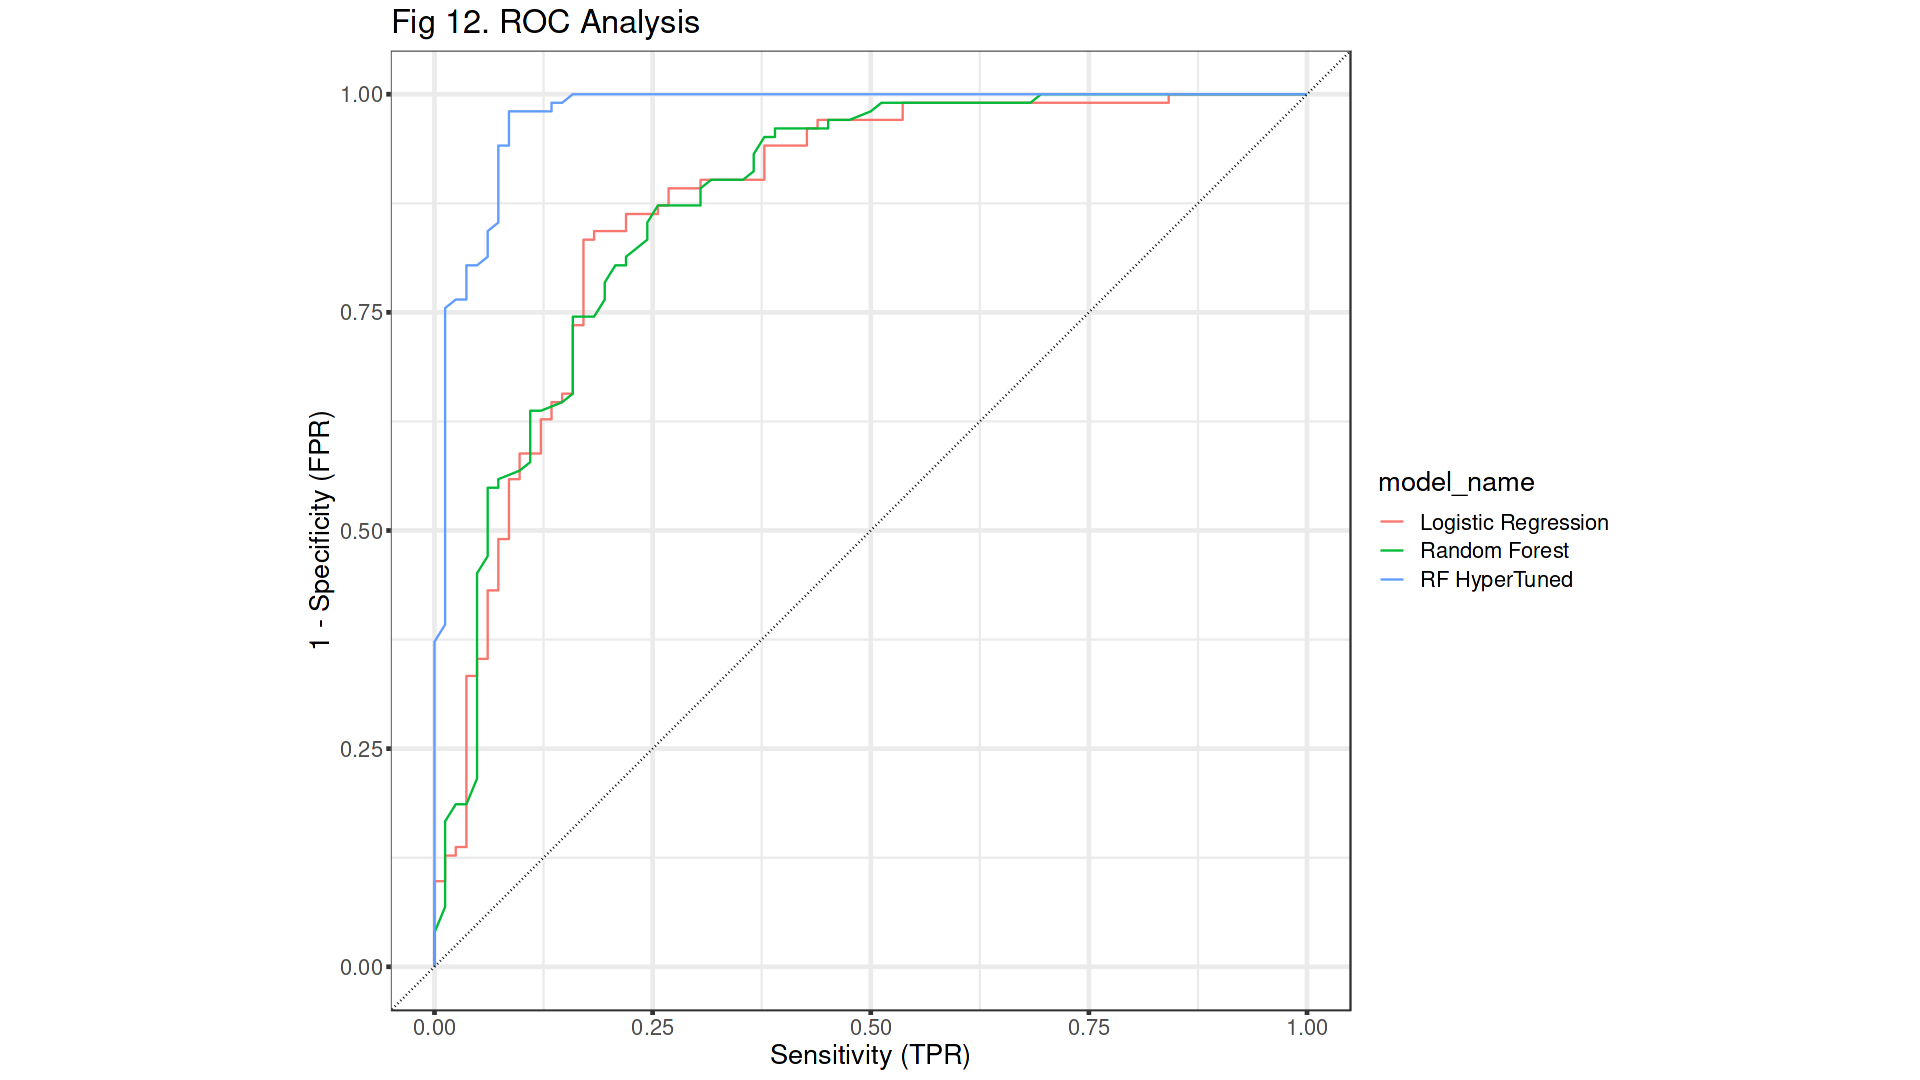

In [62]:
pred_df %>%
    group_by(model_name) %>%
    roc_curve(truth=actual_class, proba_0) %>%
    autoplot() +
    labs(title="Fig 12. ROC Analysis", x="Sensitivity (TPR)", y="1 - Specificity (FPR)") +
    theme(text = element_text(size = 16), element_line(size = 1))

**ROC Analysis Description** 
> - Hyperparameter Tuned Random Forest performs `significantly better` than the baseline models

## Recursive Feature Selection   <a class="anchor"  id="rf_rfe"></a>[↑](#top)

> - External Feature Selection, for selecting the subset of features that performs approximately equivalent to the model performance with all the features.

In [63]:
# setting the train control 
folds <- 5                                                               # number of folds to be created
cvIndex <- createFolds(train_dataset$class, folds, returnTrain = T)         # indexes of each folds
ctrl <- trainControl(
    index = cvIndex, 
    method = 'repeatedcv', 
    number = folds,
    repeats = 5, 
    classProbs = TRUE,
    summaryFunction = twoClassSummary
)

rctrl1 <- rfeControl(
    method = "repeatedcv",
    number = folds,
    repeats = 5,
    returnResamp = "all",
    functions = caretFuncs,
    saveDetails = TRUE
)

rf_profile <- rfe(
    class ~ ., 
    data=train_dataset,
    sizes = seq(18, 6, -2),
    method = "rf",
    .mtry = 2,
    ntree=250,
    rfeControl = rctrl1
)

In [64]:
rf_profile


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         6   0.7832 0.5574    0.02662 0.05597         
         8   0.7862 0.5631    0.02688 0.05593         
        10   0.8125 0.6172    0.02539 0.05266         
        12   0.8084 0.6085    0.02556 0.05286         
        14   0.8098 0.6112    0.02737 0.05679         
        16   0.8174 0.6273    0.02792 0.05712        *
        18   0.8171 0.6270    0.03148 0.06415         
        28   0.8155 0.6232    0.03089 0.06310         

The top 5 variables (out of 16):
   cp4, thalach, oldpeak, exang1, chol


## Q&A  <a class="anchor"  id="qna"></a>[↑](#top)

#### Question 1 
<hr/>

**1. Did you undertake any prepossessing? If so, why?**
> Yes, data preprocessing was conducted. Columns were split into categorical and numerical types of features.
> * [Outlier Treatment](#dp_viz_outlier) was performed for both types of features. Suspicious outlier in the columns were converted to `NA` and imputed. The reason for imputation is mentioned under the linked section. `Trestbps, Chol columns had noisy zero values and Oldpeak had noisy negative values`.
> * [Encoding](#dp_enc) was performed to `encode string categories into numbers`. The numbers then were encoded as factors. 
> * `Age column was binned to age groups` to convert into meaningful values.
> * Columns like `pace_maker, traponin were excluded` after inspection due to suspicious data values. There were only zero values in the pace maker column which did not add any valuable info. Troponin column had negative values in it and suspiciously followed normal distribution. Tropnin value cannot be negative as per internet research. [(4)](#reference)

**2. Run the classifier with default parameters.**
> *a. How accurately can the classifier predict those that develop heart disease? What is in the output that signifies this?*
  > * The `confusion matrix and report` is used for understanding the model preformance, on the test dataset.
  > * `No Information Rate (NIR)` is significantly greater than the accuracy, as stated by the pvalue in the report.
  > * For baseline `Logistic Regression` the `Sensitivity / Recall: ~ 0.82 , Pos Pred Value / Precision: ~ 0.83, Accuracy: ~ 0.82, Specificity: ~ 0.79`.
  > * For baseline `Random Forest` the `Sensitivity / Recall: ~ 0.78 , Pos Pred Value / Precision: ~ 0.87, Accuracy: ~ 0.79, Specificity: ~ 0.81`. 
  
> *b. How many people are misclassified as developing heart disease? Where is this answer found in the output?*
  > * `False Positives in the confusion matrix` states the misclassifications as developing heart disease.
  > * For Logistic Regression 17 / 102 positive predictions were misclassified as developing heart disease but in reference.
  > * For Random Forest 13 / 102 positive predtictions are False Positives.
  > * For Hypertuned Random Forest 9 / 102 positive predictions are false positives
 

**3. Plot and submit ROC curves for the class that develops heart disease.**
> *a. What is another measure of accuracy commonly used?*
  > * [ROC Analysis](#roc)
  > * `F1 score, harmonic mean of precision and recall`, states if the value is closer to 1, the model is performing good and if closer to zero, the performance is unsatisfactory

#### Question 2
<hr/>

**1. Why did you choose this classifier over the other?**

`Random Forest (RF) Classifier was selected over Logistic Regression (LR)` because of the following reasons:
  > + `Linearity and Non-Linearity both` can be explained by RF, but LR is restricted to Linearity
  > + RF has more `number of hyperparameters to tune` than LR, that makes it more capable to explore feature space inorder to model latent patterns.
  > + RF `handles outliers, noise and NA values` more robustly than LR
  > + `Singularity` does not affect RF.
  > + On comparison, in the confusion matrix report, `Mcnemar's Test P-Value RF < Mcnemar's Test P-Value LR`, which indicates that `LR model is more biased than the RF model`.
  > + RF had lower `false positives` than LR 

**2. Explain how this classifier works from a theoretical point of view – try to include as much detail as possible.**
> - Random Forest belongs to `statistical machine learning algorithm` family. It is an application of one of the ensemble technique called as `Bagging / Bootstrap Aggregating`.
> - Ensemble is a technique where multiple weak learners / models are collected to form predictions. Bagging is a type of ensemble technique where the predictions from the models are formed by bootstrapping the data and features. Random Forest is such a bagged estimate on collection of decision trees, 
> - **Bagging** is performed as a bootstrap sample $b_{[1-B]}$ with replacement is created from the dataset, where $B$ is the number of bootstrap samples to be created. Then, models $m_{[1-M]}$ are trained on each bootstrap samples such that, Predctions $P = ({1 \over M}) * (p[1] + p[2] + ... + p[m])$ where $p$ is the prediction from each model $m$.
> - **Bootstrap Feature Sampling** is performed at each split, when a sample of feature variables $v_{[1-V]}$ is selected without replacement. Subpartitions are created within using the subsample of selected variables on the boostrap sample of data. The subpartition is measured for `homogeneity` and the subsample of selected variables with the `maximum homogeneity` is selected for splitting. This process of selecting and creating splits continues until the tree is grown and total number of feature variables are explored.
> - A general rule of the thumb is select $\sqrt V$ as the number of feature variables to consider in a sample.
> - The `Out-of-bag estimate (OOBE)` error rate is measured for the trained models. The lower the error rate, the better the model. The number trees is selected where the error rate seems to be stable.
> - Random Forest is considered to be a `black box model`, as the algorithm is a collection of decision tree, the simplicity that decision tree provides of decision rules is lost.
> - To improve the Random Forest, the **hyperparameters** such as `Number of trees in the forest - ntree`, `Number of features to be considered at each split - mtry`, `Complexity of each tree - nodesize (min number of nodes / leaves in the tree), maxnodes (number of nodes / leaves in the tree)`, `sampling scheme - sample size with or without replacement`, `Splitting rule - minimize gini impurity`.
> - In the above RF tuning implementation `ntree and mtry` were hypertuned, as these have the largest impact on accuracy while others have marginal impact

**3. Try to optimize the classifier to achieve a higher accuracy (no matter how small) than first found. Remember that we have a particular focus on predicting those that develop heart disease.** 
> *a. Were there any features that could be removed? Please print the output that helped you make this decision.*
  > - Initially, during [EDA](#dp_viz), `pace_maker and traponin` columns were excluded.
  > - By default Random Forest is one of those algorithms that has `built-in feature sampling`. However an external feature selection method was also tried.
  > - [Recursive Feature Selection](#rf_rfe) shows the top 5 features selected from the given list of features. A Minimum of 10-12 features could be selected for a decent enough model with 80% accuracy.
  
> *b. Did changing the way data is sampled during training/testing affect the accuracy?*
  > - Dataset is sampled using `Repeated K-fold cross validation` when training the baseline models. This approach was chosen to obtain a robust model on the available dataset.
  > - There was no change in the dataset sampling method, as sampling and process were kept constant to ensure testing consistency. 
  
> *c. What about some of the internal parameters specific to the classifier? Please explain how one of these parameters can affect accuracy.*
  > - `ntree`, is one of the internal parameter considered for the hyperparameter tuning. ntree is the number of trees or number of smaller models to form during the model training phase. As the ntree increases, more the number of models considered for bagging / model averaging. Thus the model accuracy increases as more models / trees are introduced to model the data.
  > - `mtry`, is one the internal parameter considered for the hyperparameter tuning.It controls the variable split randomization process. It helps balance the low tree correlation while maintaining the strength of prediction


**4. In general, a classifier is only as good as the data it is trained on.**

> *Please comment on what is needed from training data to train a good classifier.*
    > - A good classifier only exists for a short period of time. To obtain consistent or robust model, timely model refresh is required. It is proven that with time data drifts. Data drift results in development of new features or change in the relationship with the target variables. 
    > - Given a point in time, to obtain a high quality classifier will be defined by data with class balance, sample size greater than 30 for each unique pattern, large number of features so that best features could be engineered and robust validation methods.
    > - Holding out dataset / validation dataset using cross validation is not completely measuring the correct model performance as the validation set is part of the entire dataset and will have the distribution intune with the dataset. To solve this, completely new dataset should be used for validation purposes.

> *How can utilizing classifiers help feed back into healthcare settings with regards to data collection?*
    > - Classifiers can help in identify a `health outcome` and `explain the relationships` of the prominent features to the outcome.
    > - Prominent features could be focused in, to collect and highlight discrepancies found during data analysis and modelling. This could be provided as feedback to data collectors to improve the collection process or fix the instruments that generate or capture invalid values.
    > - Selected significant features that has strong association with the outcome variable could be used to reinforce the idea of importance of the collected features and maintain a healthy stream of data collection and monitor it closely for any `systematic bias`.

  ## Reference  <a class="anchor"  id="reference"></a>[↑](#top)
  
  
  1.	Nikus KC, Eskola MJ, Virtanen VK, Vikman S, Niemelä KO, Huhtala H, et al. ST‐Depression with Negative T Waves in Leads V4–V5—A Marker of Severe Coronary Artery Disease in Non‐ST Elevation Acute Coronary Syndrome: A Prospective Study of Angina at Rest, with Troponin, Clinical, Electrocardiographic, and Angiographic Correlation. Ann Noninvasive Electrocardiol Off J Int Soc Holter Noninvasive Electrocardiol Inc. 2004 Jul 5;9(3):207–14. 
  
2.	Burns E, Buttner R, Buttner EB and R. T wave [Internet]. Life in the Fast Lane • LITFL. 2018 [cited 2024 Feb 23]. Available from: https://litfl.com/t-wave-ecg-library/

3.	PhD DAR MD. Cardiovascular Education. 2018 [cited 2024 Feb 23]. The ST segment: physiology, normal appearance, ST depression & ST elevation –. Available from: https://ecgwaves.com/st-segment-normal-abnormal-depression-elevation-causes/


4. Trop w  header.pdf [Internet]. [cited 2024 Feb 23]. Available from: https://www.nbt.nhs.uk/sites/default/files/Trop%20w%20%20header.pdf

5. Japkowicz N, Shah M. Evaluating Learning Algorithms: A Classification Perspective [Internet]. Cambridge University Press; 2011. Available from: https://books.google.co.uk/books?id=VoWIIOKVzR4C

6. Suman S, Pravalika J, Manjula P, Farooq U. Gender and CVD- Does It Really Matters? Curr Probl Cardiol. 2023 May;48(5):101604. 

7. 	British Heart Foundation [Internet]. [cited 2024 Feb 23]. High cholesterol - symptoms, causes & levels. Available from: https://www.bhf.org.uk/informationsupport/risk-factors/high-cholesterol


8. Wood JC. CARDIAC COMPLICATIONS IN THALASSEMIA MAJOR. Hemoglobin. 2009;33(Suppl 1):S81–6. 

9. Lanza GA, Mustilli M, Sestito A, Infusino F, Sgueglia GA, Crea F. Diagnostic and prognostic value of ST segment depression limited to the recovery phase of exercise stress test. Heart. 2004 Dec;90(12):1417–21. 

10. Palatini P. Role of Elevated Heart Rate in the Development of Cardiovascular Disease in Hypertension. Hypertension. 2011 Nov;58(5):745–50. 
  